In [202]:
import numpy as np
import pandas as pd
import requests
from datetime import date
from dateutil.relativedelta import relativedelta
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

<h1 style="text-align: center;"><strong>DACS Architecture</strong></h1>

- Credit Score (25%)
- Assets under Management (25%)
- Volatility Score (20%)
- Asseet Quality Matrix (15%)
- Liquidity Adjusted Net worth (15%)

<h3 style="text-align: center;"><strong>Fetch Cryptocurrency Price</strong></h3>

In [125]:
def fetch_price(coin_id, period = '1y'):
    """
    Fetch historical daily prices for a cryptocurrency and return or add to a DataFrame.

    Parameters:
    - coin_id: coin ticker in Yahoo Finance e.g. 'BTC-USD'
    - period: Period to retrieve data from.

    Returns:
    - A dataframe containing price data with columns 'Date','Close' and 'Returns'
    """
    coin = yf.Ticker(f"{coin_id}-USD") # 'USD': coin-id against US Dollar by default
    coin_data = coin.history(period=f"{period}")
    coin_data.index = coin_data.index.tz_localize(None)
    coin_data['returns'] = coin_data['Close'].pct_change()
    coin_data = coin_data.dropna()
    coin_data = coin_data[['Close', 'returns']]
    coin_data = coin_data.iloc[1:]
    return coin_data

<p style="text-align: center;"><strong>The code below will simulate a user buying $100,000 worth of the total crypto market cap as if it were an asset with a description of the math below:</strong></p>

<p style="text-align: center;"><strong></strong></p>

$$\text{Portfolio Value} = I \times \frac{M_t}{M_0}$$


<p><strong>Where</strong></p>

- $I$: Is the ammount of Initial Investment
- $M_t$: Is the total crypto market cap at time t
- $M_0$: Total market cap at the time of purchase

This way, at $\text{Time}_0$, the number starts at 1.0 and gradually increases / decreases as time increases

<p style="text-align: center;"><strong>Fetch Total Crypto Market Capitalization from last year as an index</strong></p>

In [138]:
def fetch_marketcap_history(api_key, start_date, end_date):
    url = "https://pro-api.coinmarketcap.com/v1/global-metrics/quotes/historical"
    
    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': api_key,
    }

    params = {
        'time_start': start_date,   # format: 'YYYY-MM-DD'
        'time_end': end_date,       # format: 'YYYY-MM-DD'
        'interval': 'daily',
        'convert': 'USD'
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()

    # Extract and convert to DataFrame
    quotes = data['data']['quotes']
    df = pd.DataFrame([{
        'Date': q['timestamp'][:10],
        'Close': q['quote']['USD']['total_market_cap'],
    } for q in quotes])
    
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df['returns'] = df['Close'].pct_change()
    df = df.dropna()
    df = df.iloc[1:]

    return df

# Replace this with your actual API key
api_key = 'c1bde33f-30b5-4dc1-8661-3af9b8bfab4e'


# One year date range (you can adjust as needed)
start_date = (date.today() - relativedelta(days = 363)).strftime('%Y-%m-%d')
end_date = date.today().strftime('%Y-%m-%d')

total_data = fetch_marketcap_history(api_key, start_date, end_date)

In [139]:
def simulate_marketcap_investment(df_marketcap, investment_amount = 100000):
    """
    Simulate buying the total crypto market cap like an index fund.
    
    Parameters:
        df_marketcap (DataFrame): must contain 'total_market_cap' column indexed by date
        investment_amount (float): how much the user invests on the first day
        
    Returns:
        DataFrame with simulated portfolio value over time
    """
    df = df_marketcap.copy()

    # Normalize to start at 1.0 and scale to the investment amount
    # It's a bit confusing because Close is the closing price of the market cap but will be changed
    # to the closing portfolio price if the user were to invest in the total market cap
    initial_cap = df['Close'].iloc[0]
    df['index'] = df['Close'] / initial_cap
    df['portfolio_value'] = df['index'] * investment_amount

    # Building a dataframe with 'Close' and 'returns' column like the other ones in this notebook
    df['Close'] = df['portfolio_value']
    # Remove timezone info for consistency
    if df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df['returns'] = df['Close'].pct_change()
    df = df.dropna()
    df = df[['Close', 'returns']]
    df = df.iloc[1:]

    return df

In [182]:
total_data_index = simulate_marketcap_investment(total_data)
total_data_index

Close   returns
Date                               
2024-06-11   99694.513508 -0.009405
2024-06-12   96246.722032 -0.034584
2024-06-13   98167.768870  0.019960
2024-06-14   95615.571706 -0.025998
2024-06-15   94724.644931 -0.009318
...                   ...       ...
2025-05-31  128598.315656 -0.025870
2025-06-01  129299.192037  0.005450
2025-06-02  130374.804116  0.008319
2025-06-03  131153.517437  0.005973
2025-06-04  130784.326502 -0.002815

[359 rows x 2 columns]

<h3 style="text-align: center;"><strong>Volatility Score</strong></h3>

The core component of the Digital Asset Credit Score (DACS) is the volatility score, which quantifies the relative stability of each digital asset a user intends to use as collateral. This score is calculated as the ratio of the asset's volatility to that of a selected market index over the past 365 days:

$$\text{Volatility Score} = \frac{\text{normalized}(\sigma_i)}{\text{normalized}(\sigma_m)}$$


<p><strong>Where</strong></p>

- $\sigma_i$: is the standard deviation of the individual's asset's daily closing prices over the past year
- $\sigma_m$: denotes the standard deviation of the selected market index over the same time


In [167]:
def calculate_volatility_score(coin_data, index):
    """
    Calculates the coin's volatility score compared to an index.

    Inputs:
    - coin_data: coin price data stored into a dataframe to be evaluated
    - index:  market index to be compared to i.e sigma_m 

    Returns:
    - Volatility score (float): coin's std dev / index std dev
    """

    #Normalize both data
    coin_norm = coin_data['Close'] / coin_data['Close'].iloc[0]
    index_norm = index['Close'] / index['Close'].iloc[0]  

    index_volatility = np.std(index_norm)
    coin_volatility = np.std(coin_norm)

    if coin_volatility == 0:
        return 1.0

    volatility_score = coin_volatility / index_volatility
    return volatility_score 

<p style="text-align: center;"><strong>The code below fetches the BTC price from the last year (1y) as an index</strong></p>

In [101]:
btc_data_index = fetch_price('BTC', period='1y')
amount_btc = 100_000 / btc_data_index['Close'].iloc[0]  # to reflect $100k worth of btc at last year perfectly
btc_data_index['Close'] = btc_data_index['Close'] * amount_btc 
btc_data_index

Close   returns
Date                               
2024-06-07  100000.000000 -0.019992
2024-06-08   99946.912133 -0.000531
2024-06-09  100440.431008  0.004938
2024-06-10  100244.720196 -0.001949
2024-06-11   97100.548443 -0.031365
...                   ...       ...
2025-05-31  150900.189740  0.006149
2025-06-01  152362.505860  0.009691
2025-06-02  152693.369909  0.002172
2025-06-03  152045.770034 -0.004241
2025-06-05  151570.570529 -0.003125

[363 rows x 2 columns]

<h3 style="text-align: center;"><strong>Visualization functions</strong></h3>

In [217]:
def plot_returns(portfolio_df, index_dict, investment_amount=100000):
    """
    Plot daily returns of the portfolio against multiple indices.

    Parameters:
    - portfolio_df: DataFrame with a 'returns' column.
    - index_dict: Dict of name -> DataFrame, each with a 'returns' column.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_df.index, portfolio_df['returns'], label='Portfolio Returns', color='blue')

    colors = cm.get_cmap('Set1', len(index_dict))
    for i, (name, df) in enumerate(index_dict.items()):
        plt.plot(df.index, df['returns'], label=f'{name} Returns', color=colors(i))

    plt.title('Daily Returns: Portfolio vs Indices')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_price(portfolio_df, index_dict, investment_amount=100000):
    """
    Plot closing prices of the portfolio against multiple indices.

    Parameters:
    - portfolio_df: DataFrame with a 'Close' column.
    - index_dict: Dict of name -> DataFrame, each with a 'Close' column.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_df.index, portfolio_df['Close'], label='Portfolio Price', color='blue')
    
    colors = cm.get_cmap('Set1', len(index_dict))
    for i, (name, df) in enumerate(index_dict.items()):
        plt.plot(df.index, df['Close'], label=f'{name} Price', color=colors(i))

    plt.title('Price Trend: Portfolio vs Indices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



<h3 style="text-align: center;"><strong>Asset Quality Matrix</strong></h3>

Asset Quality is measured as the 'quality' of the underlying asset which can be applied inclusively to all digital assets not limited to cryptocurrencies. The 'quality' of an asset is a measure for the likelihood that the asset will continue delivering expected returns in the long run. It is essentially calculated like how the beta ratio in finance is calculated:

$$\text{Asset Quality} = \frac{\text{Covariance}(R_i, R_m)}{\text{Variance}(R_m)}$$


<p><strong>Where</strong></p>

- $R_i$: Return of asset i
- $R_m$: Return of the market


One of the core data for $R_m$ is the Treasury Inflation Protected Securities (TIPS) data which are the United States Treasury bonds adjusted for inflation. By comparing each asset’s returns and the volatility of their returns to that of TIPS, the AQM provides a normalized assessment of its relative stability and risk.

In [235]:
def calculate_AQM(coin_dict, index_data):
    """ 
    Calculates the Asset Quality Matrix (AQM) for a coin compared to an index.
    Inputs:
    - coin_dict: Dictionary mapping coin names to the price Dataframes (must contain column 'Close')
    - index_data: Market DataFrame with 'Close' and 'returns' columns for the index.

    Returns:
    - AQM score (float): Coin's 'asset quality'compared to the index.
    """
    aqm_scores = {}

    for name, coin_df in coin_dict.items():

        common_dates = coin_df.index.intersection(index_data.index)
        coin_aligned = coin_df.loc[common_dates]
        index_aligned = index_data.loc[common_dates]


        index_var = np.var(index_aligned['returns'])

        covar = np.cov(coin_aligned['returns'], index_aligned['returns'])[0][1]


        aqm = covar / index_var if index_var != 0 else 0
        aqm_scores[name] = aqm



    return aqm_scores

In [193]:
tip = yf.Ticker("TIP")
tip_data = tip.history(period="1y")  
tip_data = tip_data[['Close']]
amount_tip = 100_000 / tip_data['Close'].iloc[0] # to reflect $100k worth of TIP at last year perfectly
tip_data.index = tip_data.index.tz_localize(None)
tip_data['Close'] = tip_data['Close'] * amount_tip
tip_data['returns'] = tip_data['Close'].pct_change().dropna()
tip_data = tip_data.iloc[1:] 

market_var = np.var(tip_data['returns'])

tip_data

Close   returns
Date                               
2024-06-06   99915.899270 -0.000841
2024-06-07   99093.631367 -0.008230
2024-06-10   98953.458611 -0.001415
2024-06-11   99224.449040  0.002739
2024-06-12   99373.940336  0.001507
...                   ...       ...
2025-05-29  104089.976307  0.002854
2025-05-30  104433.980232  0.003305
2025-06-02  104082.404537 -0.003366
2025-06-03  103986.609953 -0.000920
2025-06-04  104388.951589  0.003869

[249 rows x 2 columns]

In [277]:
def build_portfolio(coin_dict, weights, investment_amount=100000):
    """
    Build a portfolio to return the amount of tokens for each coin of the user.
    Inputs:
    - Coins: a dictionary mapping coin names to price data DataFrames
    - Weights: a list of weights for each coin in the portfolio
    - Investment Amount: the total amount of money the user invests in the portfolio

    Returns:
    a list of amounts of tokens for each coin in the portfolio.

    This function should not be needed in a real-life setting where the portfolio is displayed as amount of
    tokens instead of percentages which is used for the simulation
    """
    coin_names = list(coin_dict.keys())
    coins = list(coin_dict.values())

    initial_prices = [coin['Close'].iloc[0] for coin in coins]
    initial_prices = np.array(initial_prices)
    weights = np.array(weights)
    allocation = weights * investment_amount
    amount_list = allocation / initial_prices

    # This is to just double check that the total_amount = investment_amount and the weights were distributed properly
    total_amount = 0

    print(" Portfolio Breakdown:")
    for name, price, alloc, amount in zip(coin_names, initial_prices, allocation, amount_list):
        print(f" - {name}:")
        print(f"    Price: ${price:,.2f}")
        print(f"    Allocation: ${alloc:,.2f}")
        print(f"    Total {name} Purchased: {amount:,.6f}")
        total_amount += alloc
        
    print('Total Amount Invested: ${:,.2f}'.format(total_amount))
    return amount_list


In [175]:
def build_portfolio_time_series(coin_dict, amount, investment_amount=100000):
    """
    Construct a time series of portfolio value and daily returns.

    Parameters:
    - coin_dict: dict mapping coin names to price DataFrames (must contain 'Close')
    - weights: list of portfolio weights
    - investment_amount: total initial investment

    Returns:
    - portfolio_df: DataFrame with columns 'Close' (portfolio value) and 'returns'
    """
    coin_names = list(coin_dict.keys())
    coin_dfs = list(coin_dict.values())

    portfolio_series = None
    for name, df, amount in zip(coin_names, coin_dfs, amount):
        weighted_price = df['Close'] * amount
        if portfolio_series is None:
            portfolio_series = weighted_price.copy()
        else:
            portfolio_series += weighted_price

    portfolio_df = coin_dfs[0].copy()
    portfolio_df['Close'] = portfolio_series
    portfolio_df['returns'] = portfolio_df['Close'].pct_change()

    portfolio_df = portfolio_df.dropna(subset=['returns'])

    return portfolio_df


<h5>Index Dictionary for better Visualization</h5>

In [194]:
index_dict = {
    'Bitcoin': btc_data_index,
    'Total Crypto Market Cap': total_data_index,
    'Treasury Inflation Protected Securities': tip_data
    }

<h2 style="text-align: center;"><strong>Portfolio Simulations for Volatility Score and AQM</strong></h2>

<h3 style="text-align: center;"><strong>Conservative Portfolio</strong></h3>

<ul>
<li>USDC: 50%</li>
<li>BTC: 30%</li>
<li>ETH: 20%</li>
</ul>

In [253]:
USDC_data = fetch_price('USDC', period='1y')
BTC_data = fetch_price('BTC', period='1y')
ETH_data = fetch_price('ETH', period='1y')

In [279]:
"""This Dictionary will be continuously built to store price data of each coin of the user base"""
coin_dict = {
    'USDC': USDC_data,
    'BTC': BTC_data,
    'ETH': ETH_data,
}

In [280]:
portfolio_1 = build_portfolio(coin_dict, [0.5, 0.3, 0.2], investment_amount=100000)
#Last update June 4 2025 so the prices are for June 4 2024, 1 year prior

 Portfolio Breakdown:
 - USDC:
    Price: $1.00
    Allocation: $50,000.00
    Total USDC Purchased: 49,995.351270
 - BTC:
    Price: $69,342.59
    Allocation: $30,000.00
    Total BTC Purchased: 0.432635
 - ETH:
    Price: $3,678.63
    Allocation: $20,000.00
    Total ETH Purchased: 5.436808
Total Amount Invested: $100,000.00


### Portfolio Data

In [143]:
portfolio_1_df = build_portfolio_time_series(coin_dict, portfolio_1)
portfolio_1_df

Close   returns
Date                               
2024-06-08   99992.841286 -0.000072
2024-06-09  100273.368785  0.002805
2024-06-10  100000.755002 -0.002719
2024-06-11   98149.367457 -0.018514
2024-06-12   98870.506443  0.007347
...                   ...       ...
2025-05-31  109007.170049  0.002543
2025-06-01  109480.798047  0.004345
2025-06-02  109972.601986  0.004492
2025-06-03  109693.849796 -0.002535
2025-06-05  109790.897023  0.000885

[362 rows x 2 columns]

<h3>Volatility Score:</h3>

<h4>Against BTC</h4>

In [256]:
USDC_score_btc = calculate_volatility_score(USDC_data, BTC_data)
BTC_score_btc = calculate_volatility_score(BTC_data, BTC_data)
ETH_score_btc = calculate_volatility_score(ETH_data, BTC_data)

<h4>Against Total</h4>

In [258]:
USDC_score_total = calculate_volatility_score(USDC_data, total_data)
BTC_score_total = calculate_volatility_score(BTC_data, total_data)
ETH_score_total = calculate_volatility_score(ETH_data, total_data)

In [296]:
portfolio_1_vol_score = [
    {'coin': 'BTC',      'volatility_score_btc': BTC_score_btc},
    {'coin': 'USDC',     'volatility_score_btc': USDC_score_btc},
    {'coin': 'ETH',       'volatility_score_btc': ETH_score_btc}
]

vol_scores = pd.DataFrame(portfolio_1_vol_score)

vol_scores['volatility_score_total'] = [
    BTC_score_total,
    USDC_score_total,
    ETH_score_total
]
vol_scores

coin  volatility_score_btc  volatility_score_total
0   BTC              1.000000                1.188346
1  USDC              0.000446                0.000530
2   ETH              0.674713                0.801793

### Portfolio Price visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/1912671181.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


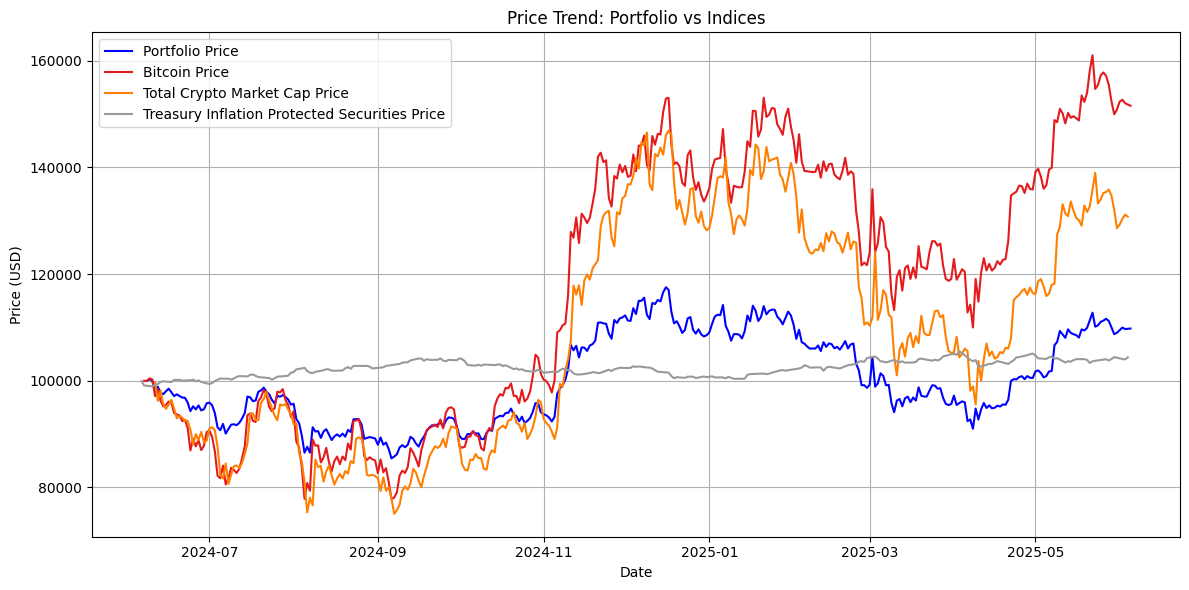

In [215]:
plot_price(portfolio_1_df, index_dict)

### Portfolio Returns visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


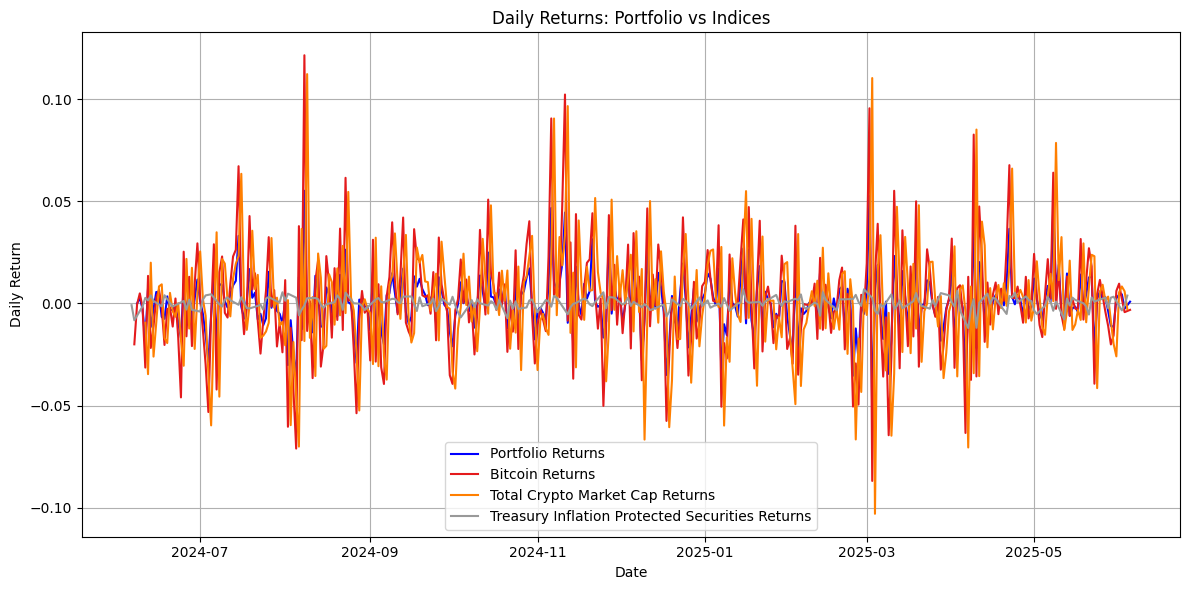

In [218]:
plot_returns(portfolio_1_df, index_dict)

In [220]:
overall_vol_score_1 = calculate_volatility_score(portfolio_1_df, total_data_index)
print(f"Overall Volatility Score: {overall_vol_score_1:.3f}")

Overall Volatility Score: 0.402


#### AQM Score:

In [266]:
aqm_1 = calculate_AQM(coin_dict, tip_data)
aqm_df = pd.DataFrame(aqm_1.items(), columns=['Coin', 'AQM'])
aqm_df

Coin       AQM
0  USDC -0.004614
1   BTC -0.290746
2   ETH  0.760443

<h3 style="text-align: center;"><strong>Balanced Portfolio</strong></h3>

<ul>
<li>USDC: 30%</li>
<li>BTC: 20%</li>
<li>ETH: 20%</li>
<li>ADA: 15%</li>
<li>SOL: 15%</li>
</ul>

In [281]:
"""building on coin_dict:"""
ADA_data = fetch_price('ADA', period='1y')
SOL_data = fetch_price('SOL', period='1y')
coin_dict['ADA'] = ADA_data
coin_dict['SOL'] = SOL_data

In [282]:
portfolio_2 = build_portfolio(coin_dict, [0.3, 0.2, 0.2, 0.15, 0.15], investment_amount=100000)

 Portfolio Breakdown:
 - USDC:
    Price: $1.00
    Allocation: $30,000.00
    Total USDC Purchased: 29,997.210762
 - BTC:
    Price: $69,342.59
    Allocation: $20,000.00
    Total BTC Purchased: 0.288423
 - ETH:
    Price: $3,678.63
    Allocation: $20,000.00
    Total ETH Purchased: 5.436808
 - ADA:
    Price: $0.45
    Allocation: $15,000.00
    Total ADA Purchased: 33,359.799808
 - SOL:
    Price: $162.51
    Allocation: $15,000.00
    Total SOL Purchased: 92.303688
Total Amount Invested: $100,000.00


<h3>Portfolio Data</h3>

In [248]:
portfolio_2_df = build_portfolio_time_series(coin_dict, portfolio_2)
portfolio_2_df

Close   returns
Date                               
2024-06-08   99144.723640 -0.008553
2024-06-09  100008.346708  0.008711
2024-06-10   99342.776803 -0.006655
2024-06-11   96306.577830 -0.030563
2024-06-12   97959.968477  0.017168
...                   ...       ...
2025-05-31  111268.015124  0.001001
2025-06-01  111666.097627  0.003578
2025-06-02  112206.130502  0.004836
2025-06-03  111674.225529 -0.004740
2025-06-05  110442.924464 -0.011026

[362 rows x 2 columns]

### Volatility Score:

<h4>Against BTC</h4>

In [249]:
ADA_score_btc = calculate_volatility_score(ADA_data, BTC_data)
SOL_score_btc = calculate_volatility_score(SOL_data, BTC_data)

<h4>Against Total Crypto Market Capitalization</h4>


In [260]:
ADA_score_total = calculate_volatility_score(ADA_data, total_data)
SOL_score_total = calculate_volatility_score(SOL_data, total_data)

In [297]:
new_rows = [
    {
        'coin': 'ADA',
        'volatility_score_btc': ADA_score_btc,
        'volatility_score_total': ADA_score_total
    },
    {
        'coin': 'SOL',
        'volatility_score_btc': SOL_score_btc,
        'volatility_score_total': SOL_score_total
    }
]


new_df = pd.DataFrame(new_rows)
vol_scores = pd.concat([vol_scores, new_df], ignore_index=True)
vol_scores

coin  volatility_score_btc  volatility_score_total
0   BTC              1.000000                1.188346
1  USDC              0.000446                0.000530
2   ETH              0.674713                0.801793
3   ADA              2.309213                2.741786
4   SOL              0.897110                1.065161

### Portfolio Price Visualization:

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


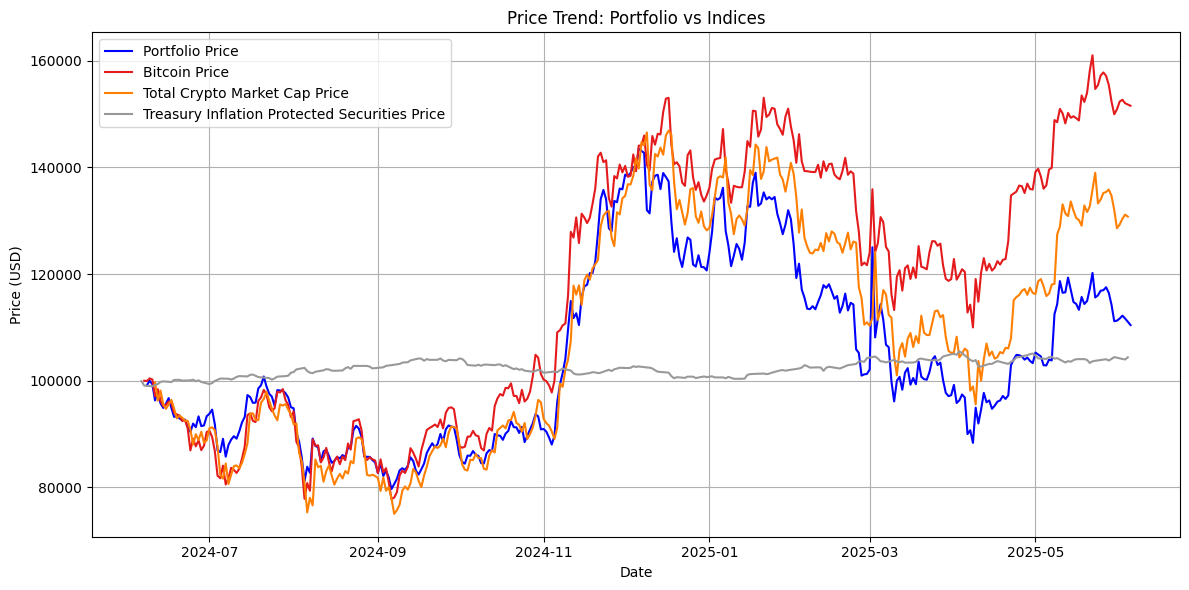

In [263]:
plot_price(portfolio_2_df, index_dict)

### Portfolio Returns Visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


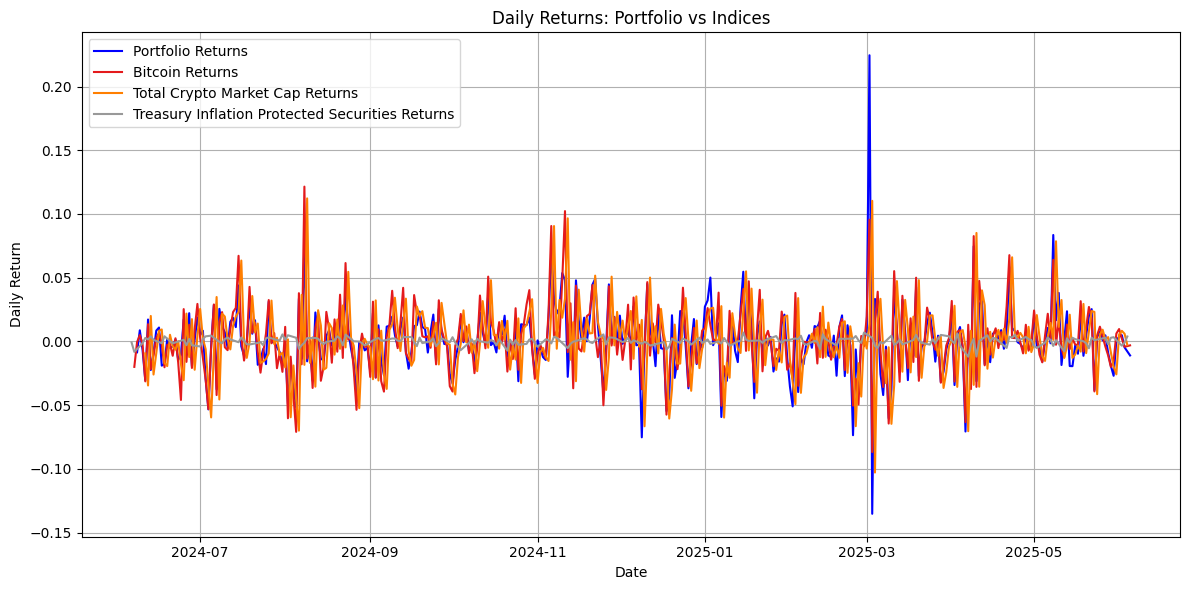

In [264]:
plot_returns(portfolio_2_df, index_dict)

In [265]:
overall_vol_score_2 = calculate_volatility_score(portfolio_2_df, total_data_index)
print(f"Overall Volatility Score: {overall_vol_score_2:.3f}")

Overall Volatility Score: 0.818


### AQM Score:

In [270]:
aqm_2 = calculate_AQM(coin_dict, tip_data)
aqm_df = pd.DataFrame(aqm_2.items(), columns=['Coin', 'AQM'])
aqm_df

Coin       AQM
0  USDC -0.004614
1   BTC -0.290746
2   ETH  0.760443
3   ADA -0.189229
4   SOL  0.096127

<h3 style="text-align: center;"><strong>Growth-Oriented Portfolio</strong></h3>

<ul>
<li>USDC: 10%</li>
<li>BTC: 25%</li>
<li>ETH: 20%</li>
<li>SOL: 20%</li>
<li>DOT: 15%</li>
<li>LINK: 10%</li>
</ul>

In [283]:
"""Building on coin_dict:"""
DOT_data = fetch_price('DOT', period='1y')
LINK_data = fetch_price('LINK', period='1y')

coin_dict['DOT'] = DOT_data
coin_dict['LINK'] = LINK_data
print(coin_dict.keys())

dict_keys(['USDC', 'BTC', 'ETH', 'ADA', 'SOL', 'DOT', 'LINK'])


In [288]:
portfolio_3 = build_portfolio(coin_dict, [0.1, 0.25, 0.20, 0, 0.20, 0.15, 0.1], investment_amount=100000)

 Portfolio Breakdown:
 - USDC:
    Price: $1.00
    Allocation: $10,000.00
    Total USDC Purchased: 9,999.070254
 - BTC:
    Price: $69,342.59
    Allocation: $25,000.00
    Total BTC Purchased: 0.360529
 - ETH:
    Price: $3,678.63
    Allocation: $20,000.00
    Total ETH Purchased: 5.436808
 - ADA:
    Price: $0.45
    Allocation: $0.00
    Total ADA Purchased: 0.000000
 - SOL:
    Price: $162.51
    Allocation: $20,000.00
    Total SOL Purchased: 123.071584
 - DOT:
    Price: $6.66
    Allocation: $15,000.00
    Total DOT Purchased: 2,253.007714
 - LINK:
    Price: $16.33
    Allocation: $10,000.00
    Total LINK Purchased: 612.456002
Total Amount Invested: $100,000.00


<h3>Portfolio Data</h3>

In [289]:
portfolio_3_df = build_portfolio_time_series(coin_dict, portfolio_3)
portfolio_3_df

Close   returns
Date                              
2024-06-08  98598.544173 -0.014015
2024-06-09  99919.012255  0.013392
2024-06-10  98950.555531 -0.009692
2024-06-11  95243.796380 -0.037461
2024-06-12  98041.859073  0.029378
...                  ...       ...
2025-06-01  99064.488114  0.005660
2025-06-02  99638.626151  0.005796
2025-06-03  99200.124427 -0.004401
2025-06-04  98347.212833 -0.008598
2025-06-05  96976.600852 -0.013936

[363 rows x 2 columns]

<h3> Volatility Score</h3>

<h4>Against BTC</h4>

In [290]:
DOT_score_btc = calculate_volatility_score(DOT_data, BTC_data)
LINK_score_btc = calculate_volatility_score(LINK_data, BTC_data)

<h4>Against Total Crypto Market Capitalization</h4>

In [291]:
DOT_score_total = calculate_volatility_score(DOT_data, total_data)
LINK_score_total = calculate_volatility_score(LINK_data, total_data)

In [298]:
new_rows = [
    {
        'coin': 'DOT',
        'volatility_score_btc': DOT_score_btc,
        'volatility_score_total': DOT_score_total
    },
    {
        'coin': 'LINK',
        'volatility_score_btc': LINK_score_btc,
        'volatility_score_total': LINK_score_total
    }
]
vol_scores = pd.concat([vol_scores, pd.DataFrame(new_rows)], ignore_index=True)
vol_scores

coin  volatility_score_btc  volatility_score_total
0   BTC              1.000000                1.188346
1  USDC              0.000446                0.000530
2   ETH              0.674713                0.801793
3   ADA              2.309213                2.741786
4   SOL              0.897110                1.065161
5   DOT              0.896832                1.065747
6  LINK              1.124675                1.336503

### Portfolio Price Visualization:

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


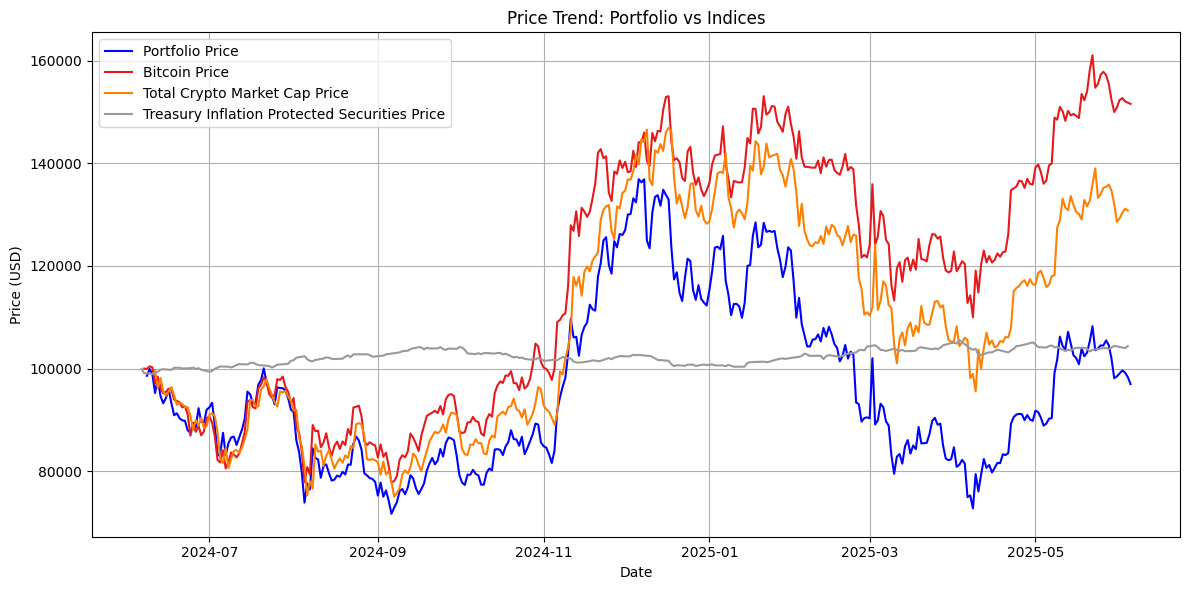

In [299]:
plot_price(portfolio_3_df, index_dict)

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


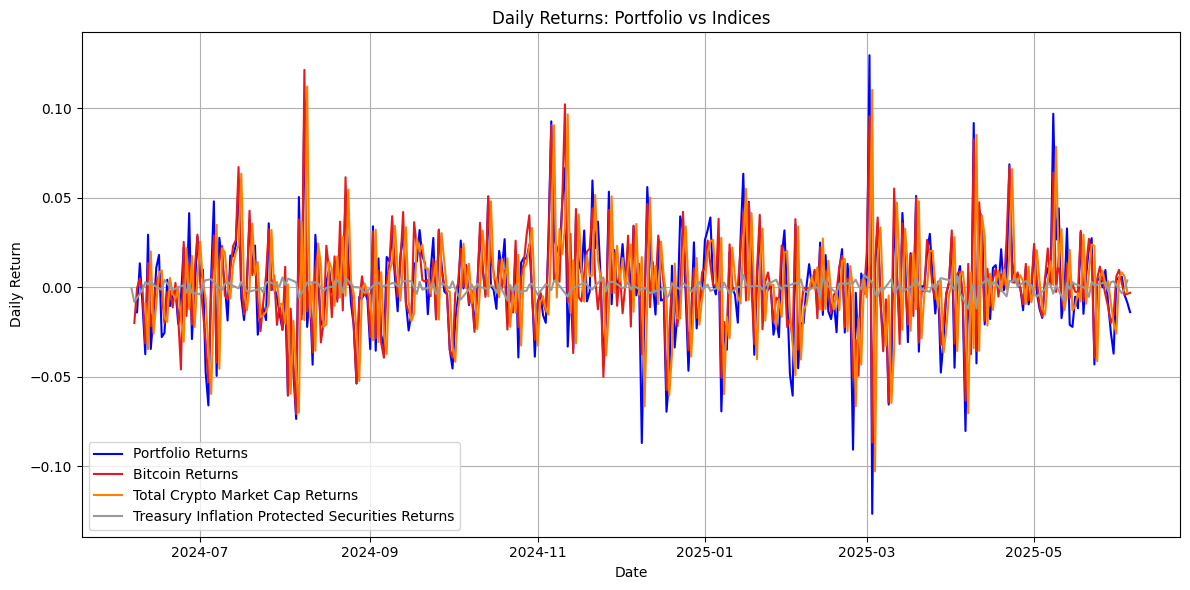

In [300]:
plot_returns(portfolio_3_df, index_dict)

In [301]:
overall_vol_score_3 = calculate_volatility_score(portfolio_3_df, total_data_index)
print(f"Overall Volatility Score: {overall_vol_score_3:.3f}")

Overall Volatility Score: 0.790


### AQM Score:

In [302]:
aqm_3 = calculate_AQM(coin_dict, tip_data)
aqm_df = pd.DataFrame(aqm_3.items(), columns=['Coin', 'AQM'])
aqm_df

Coin       AQM
0  USDC -0.004614
1   BTC -0.290746
2   ETH  0.760443
3   ADA -0.189229
4   SOL  0.096127
5   DOT  0.578391
6  LINK  0.143060

<h3 style="text-align: center;"><strong>High-Risk Portfolio</strong></h3>

- USDC: 5% 
- BTC: 20% 
- ETH: 15% 
- SOL: 20% 
- AVAX: 15% 
- DOGE: 10% 
- SHIB: 15%

In [304]:
"""building on coin_dict:"""
AVAX_data = fetch_price('AVAX', period='1y')
DOGE_data = fetch_price('DOGE', period='1y')
SHIB_data = fetch_price('SHIB', period='1y')
coin_dict['AVAX'] = AVAX_data
coin_dict['DOGE'] = DOGE_data
coin_dict['SHIB'] = SHIB_data
print(coin_dict.keys())

dict_keys(['USDC', 'BTC', 'ETH', 'ADA', 'SOL', 'DOT', 'LINK', 'AVAX', 'DOGE', 'SHIB'])


### Portfolio Data:

In [305]:
portfolio_4 = build_portfolio(coin_dict, [0.05, 0.20, 0.15, 0, 0.2, 0, 0, 0.15, 0.1, 0.15], investment_amount=100000)

 Portfolio Breakdown:
 - USDC:
    Price: $1.00
    Allocation: $5,000.00
    Total USDC Purchased: 4,999.535127
 - BTC:
    Price: $69,342.59
    Allocation: $20,000.00
    Total BTC Purchased: 0.288423
 - ETH:
    Price: $3,678.63
    Allocation: $15,000.00
    Total ETH Purchased: 4.077606
 - ADA:
    Price: $0.45
    Allocation: $0.00
    Total ADA Purchased: 0.000000
 - SOL:
    Price: $162.51
    Allocation: $20,000.00
    Total SOL Purchased: 123.071584
 - DOT:
    Price: $6.66
    Allocation: $0.00
    Total DOT Purchased: 0.000000
 - LINK:
    Price: $16.33
    Allocation: $0.00
    Total LINK Purchased: 0.000000
 - AVAX:
    Price: $33.51
    Allocation: $15,000.00
    Total AVAX Purchased: 447.657102
 - DOGE:
    Price: $0.15
    Allocation: $10,000.00
    Total DOGE Purchased: 67,429.518331
 - SHIB:
    Price: $0.00
    Allocation: $15,000.00
    Total SHIB Purchased: 624,999,977.893216
Total Amount Invested: $100,000.00


In [409]:
portfolio_4_df = build_portfolio_time_series(coin_dict, portfolio_4)
portfolio_4_df

Close   returns
Date                              
2024-06-08  98118.493957 -0.018815
2024-06-09  99176.906348  0.010787
2024-06-10  98141.642166 -0.010439
2024-06-11  94257.381937 -0.039578
2024-06-12  96797.407185  0.026948
...                  ...       ...
2025-06-01  95757.118537  0.005944
2025-06-02  96272.789538  0.005385
2025-06-03  95715.957923 -0.005784
2025-06-04  94553.406317 -0.012146
2025-06-05  92606.714061 -0.020588

[363 rows x 2 columns]

<h3> Volatility Score</h3>

<h4>Against BTC</h4>

In [307]:
AVAX_score_btc = calculate_volatility_score(AVAX_data, BTC_data)
DOGE_score_btc = calculate_volatility_score(DOGE_data, BTC_data)
SHIB_score_btc = calculate_volatility_score(SHIB_data, BTC_data)

<h4>Against Total Crypto Market Capitalization</h4>

In [308]:
AVAX_score_total = calculate_volatility_score(AVAX_data, total_data)
DOGE_score_total = calculate_volatility_score(DOGE_data, total_data)
SHIB_score_total = calculate_volatility_score(SHIB_data, total_data)

In [309]:
new_rows = [
    {
        'coin': 'AVAX',
        'volatility_score_btc': AVAX_score_btc,
        'volatility_score_total': AVAX_score_total
    },
    {
        'coin': 'DOGE',
        'volatility_score_btc': DOGE_score_btc,
        'volatility_score_total': DOGE_score_total
    },
    {
        'coin': 'SHIB',
        'volatility_score_btc': SHIB_score_btc,
        'volatility_score_total': SHIB_score_total
    }
]
vol_scores = pd.concat([vol_scores, pd.DataFrame(new_rows)], ignore_index=True)
vol_scores

coin  volatility_score_btc  volatility_score_total
0   BTC              1.000000                1.188346
1  USDC              0.000446                0.000530
2   ETH              0.674713                0.801793
3   ADA              2.309213                2.741786
4   SOL              0.897110                1.065161
5   DOT              0.896832                1.065747
6  LINK              1.124675                1.336503
7  AVAX              0.974209                1.157698
8  DOGE              2.787616                3.312652
9  SHIB              0.780437                0.927429

### Portfolio Price Visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


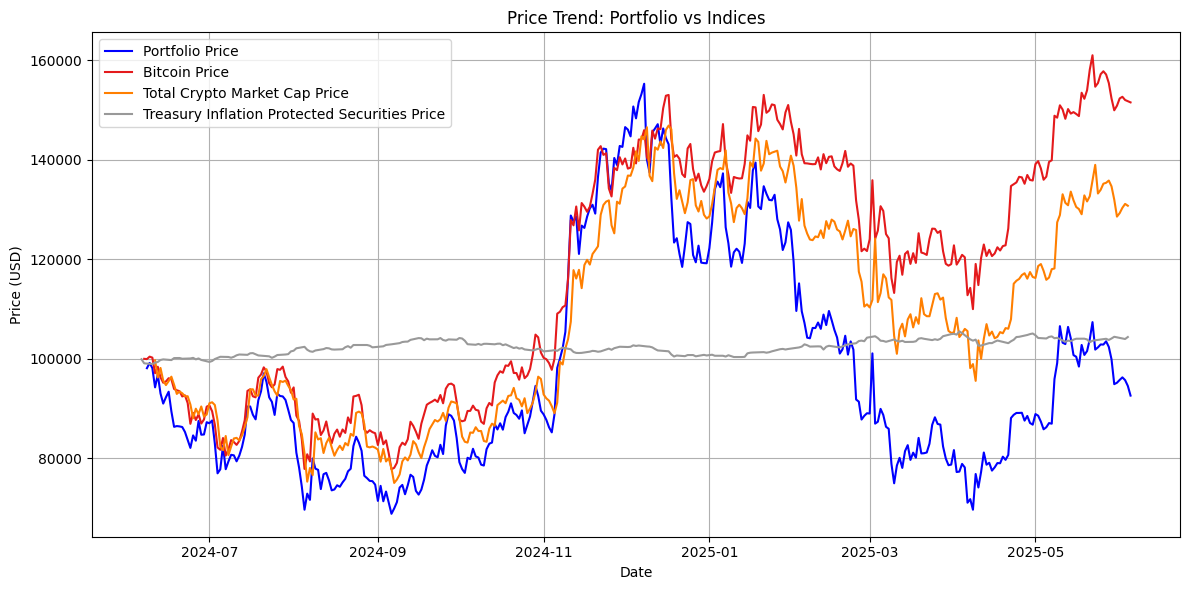

In [310]:
plot_price(portfolio_4_df, index_dict)

### Portfolio Returns Visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


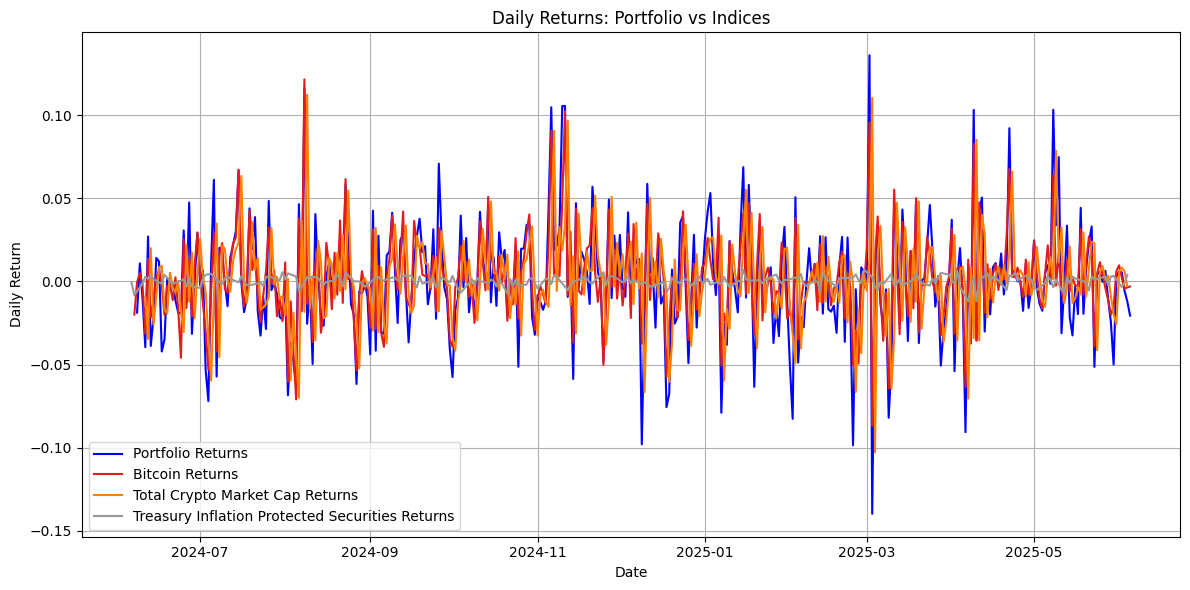

In [311]:
plot_returns(portfolio_4_df, index_dict)

In [312]:
overall_vol_score_4 = calculate_volatility_score(portfolio_4_df, total_data_index)
print(f"Overall Volatility Score: {overall_vol_score_4:.3f}")

Overall Volatility Score: 1.056


### AQM Score:

In [313]:
aqm_4 = calculate_AQM(coin_dict, tip_data)
aqm_df = pd.DataFrame(aqm_4.items(), columns=['Coin', 'AQM'])
aqm_df

Coin       AQM
0  USDC -0.004614
1   BTC -0.290746
2   ETH  0.760443
3   ADA -0.189229
4   SOL  0.096127
5   DOT  0.578391
6  LINK  0.143060
7  AVAX -0.446848
8  DOGE -1.008874
9  SHIB  0.758503

<h3 style="text-align: center;"><strong>Meme-coin Heavy Portfolio</strong></h3>

- USDC: 10%  
- BTC: 20% 
- ETH: 10% 
- DOGE: 30%
- SHIB: 30%

In [314]:
print(coin_dict.keys())

dict_keys(['USDC', 'BTC', 'ETH', 'ADA', 'SOL', 'DOT', 'LINK', 'AVAX', 'DOGE', 'SHIB'])


In [317]:
#no new coin data to fetch
portfolio_5 = build_portfolio(coin_dict, [0.1, 0.2, 0.1, 0, 0, 0, 0, 0, 0.3, 0.3])


 Portfolio Breakdown:
 - USDC:
    Price: $1.00
    Allocation: $10,000.00
    Total USDC Purchased: 9,999.070254
 - BTC:
    Price: $69,342.59
    Allocation: $20,000.00
    Total BTC Purchased: 0.288423
 - ETH:
    Price: $3,678.63
    Allocation: $10,000.00
    Total ETH Purchased: 2.718404
 - ADA:
    Price: $0.45
    Allocation: $0.00
    Total ADA Purchased: 0.000000
 - SOL:
    Price: $162.51
    Allocation: $0.00
    Total SOL Purchased: 0.000000
 - DOT:
    Price: $6.66
    Allocation: $0.00
    Total DOT Purchased: 0.000000
 - LINK:
    Price: $16.33
    Allocation: $0.00
    Total LINK Purchased: 0.000000
 - AVAX:
    Price: $33.51
    Allocation: $0.00
    Total AVAX Purchased: 0.000000
 - DOGE:
    Price: $0.15
    Allocation: $30,000.00
    Total DOGE Purchased: 202,288.554994
 - SHIB:
    Price: $0.00
    Allocation: $30,000.00
    Total SHIB Purchased: 1,249,999,955.786433
Total Amount Invested: $100,000.00


In [319]:
portfolio_5_df = build_portfolio_time_series(coin_dict, portfolio_5)
portfolio_5_df

Close   returns
Date                               
2024-06-08   98290.986260 -0.017090
2024-06-09   98601.518993  0.003159
2024-06-10   98044.228614 -0.005652
2024-06-11   94366.734830 -0.037509
2024-06-12   96431.395822  0.021879
...                   ...       ...
2025-06-01  102783.206382  0.005126
2025-06-02  103399.038713  0.005992
2025-06-03  102774.534616 -0.006040
2025-06-04  101623.151675 -0.011203
2025-06-05   99154.571453 -0.024292

[363 rows x 2 columns]

### Volatility Score:

In [320]:
# no new data
vol_scores

coin  volatility_score_btc  volatility_score_total
0   BTC              1.000000                1.188346
1  USDC              0.000446                0.000530
2   ETH              0.674713                0.801793
3   ADA              2.309213                2.741786
4   SOL              0.897110                1.065161
5   DOT              0.896832                1.065747
6  LINK              1.124675                1.336503
7  AVAX              0.974209                1.157698
8  DOGE              2.787616                3.312652
9  SHIB              0.780437                0.927429

### Portfolio Price Visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


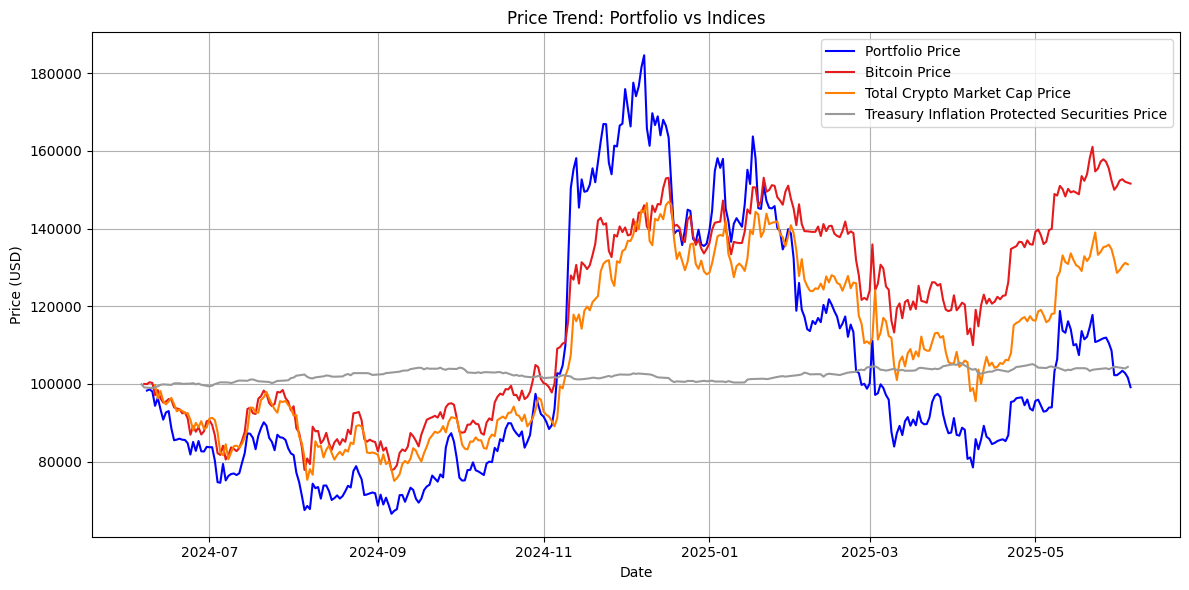

In [321]:
plot_price(portfolio_5_df, index_dict)

### Portfolio Return Visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


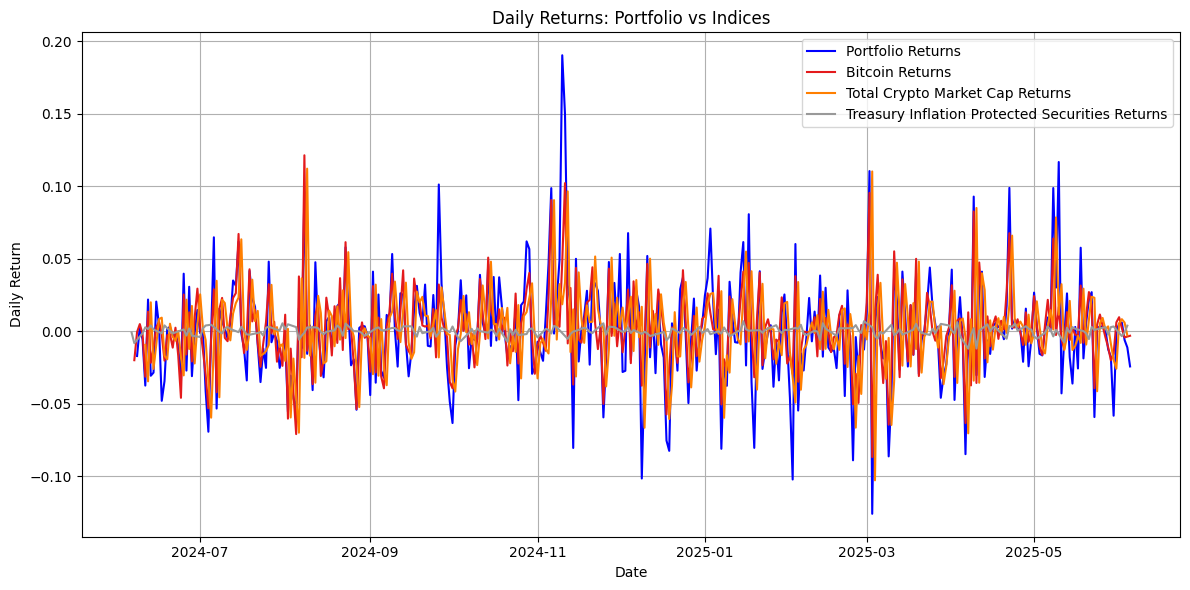

In [322]:
plot_returns(portfolio_5_df, index_dict)

In [323]:
overall_vol_score_5 = calculate_volatility_score(portfolio_5_df, total_data_index)
print(f"Overall Volatility Score: {overall_vol_score_5:.3f}")

Overall Volatility Score: 1.459


### AQM Score:

In [324]:
aqm_df

Coin       AQM
0  USDC -0.004614
1   BTC -0.290746
2   ETH  0.760443
3   ADA -0.189229
4   SOL  0.096127
5   DOT  0.578391
6  LINK  0.143060
7  AVAX -0.446848
8  DOGE -1.008874
9  SHIB  0.758503

<h3 style="text-align: center;"><strong>De-Fi Focused Portfolio</strong></h3>

- USDC: 20% 
- ETH: 25% 
- UNI: 25% 
- AAVE: 20%
- COMP: 10%

In [325]:
UNI_data = fetch_price('UNI7083', period='1y')
AAVE_data = fetch_price('AAVE', period='1y')
COMP_data = fetch_price('COMP5692', period='1y')
coin_dict['UNI'] = UNI_data
coin_dict['AAVE'] = AAVE_data
coin_dict['COMP'] = COMP_data
print(coin_dict.keys())

dict_keys(['USDC', 'BTC', 'ETH', 'ADA', 'SOL', 'DOT', 'LINK', 'AVAX', 'DOGE', 'SHIB', 'UNI', 'AAVE', 'COMP'])


In [329]:
portfolio_6 = build_portfolio(coin_dict, [0.2, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0.25, 0.2, 0.1], investment_amount=100000)

 Portfolio Breakdown:
 - USDC:
    Price: $1.00
    Allocation: $20,000.00
    Total USDC Purchased: 19,998.140508
 - BTC:
    Price: $69,342.59
    Allocation: $0.00
    Total BTC Purchased: 0.000000
 - ETH:
    Price: $3,678.63
    Allocation: $25,000.00
    Total ETH Purchased: 6.796010
 - ADA:
    Price: $0.45
    Allocation: $0.00
    Total ADA Purchased: 0.000000
 - SOL:
    Price: $162.51
    Allocation: $0.00
    Total SOL Purchased: 0.000000
 - DOT:
    Price: $6.66
    Allocation: $0.00
    Total DOT Purchased: 0.000000
 - LINK:
    Price: $16.33
    Allocation: $0.00
    Total LINK Purchased: 0.000000
 - AVAX:
    Price: $33.51
    Allocation: $0.00
    Total AVAX Purchased: 0.000000
 - DOGE:
    Price: $0.15
    Allocation: $0.00
    Total DOGE Purchased: 0.000000
 - SHIB:
    Price: $0.00
    Allocation: $0.00
    Total SHIB Purchased: 0.000000
 - UNI:
    Price: $9.82
    Allocation: $25,000.00
    Total UNI Purchased: 2,546.488194
 - AAVE:
    Price: $97.45
    Allocatio

In [330]:
portfolio_6_df = build_portfolio_time_series(coin_dict, portfolio_6)
portfolio_6_df

Close   returns
Date                               
2024-06-08   99325.849773 -0.006742
2024-06-09   99102.868990 -0.002245
2024-06-10   99473.329904  0.003738
2024-06-11   94005.638812 -0.054966
2024-06-12   97954.266597  0.042004
...                   ...       ...
2025-06-01  111075.826590  0.004015
2025-06-02  114503.907818  0.030863
2025-06-03  117180.776337  0.023378
2025-06-04  116154.867974 -0.008755
2025-06-05  113573.404689 -0.022224

[363 rows x 2 columns]

### Volatility Score:

<h4>Against BTC</h4>

In [331]:
UNI_score_btc  = calculate_volatility_score(UNI_data, BTC_data)
AAVE_score_btc = calculate_volatility_score(AAVE_data, BTC_data)
COMP_score_btc = calculate_volatility_score(COMP_data, BTC_data)

<h4>Against Total Crypto Market Capitalization</h4>

In [332]:
UNI_score_total  = calculate_volatility_score(UNI_data, total_data)
AAVE_score_total = calculate_volatility_score(AAVE_data, total_data)
COMP_score_total = calculate_volatility_score(COMP_data, total_data)

In [333]:
new_rows = [
    {
        'coin': 'UNI',
        'volatility_score_btc': UNI_score_btc,
        'volatility_score_total': UNI_score_total
    },
    {
        'coin': 'AAVE',
        'volatility_score_btc': AAVE_score_btc,
        'volatility_score_total': AAVE_score_total
    },
    {
        'coin': 'COMP',
        'volatility_score_btc': COMP_score_btc,
        'volatility_score_total': COMP_score_total
    }
]
vol_scores = pd.concat([vol_scores, pd.DataFrame(new_rows)], ignore_index=True)
vol_scores

coin  volatility_score_btc  volatility_score_total
0    BTC              1.000000                1.188346
1   USDC              0.000446                0.000530
2    ETH              0.674713                0.801793
3    ADA              2.309213                2.741786
4    SOL              0.897110                1.065161
5    DOT              0.896832                1.065747
6   LINK              1.124675                1.336503
7   AVAX              0.974209                1.157698
8   DOGE              2.787616                3.312652
9   SHIB              0.780437                0.927429
10   UNI              1.255212                1.491626
11  AAVE              3.250028                3.862158
12  COMP              1.220426                1.450289

### Portfolio Price Visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


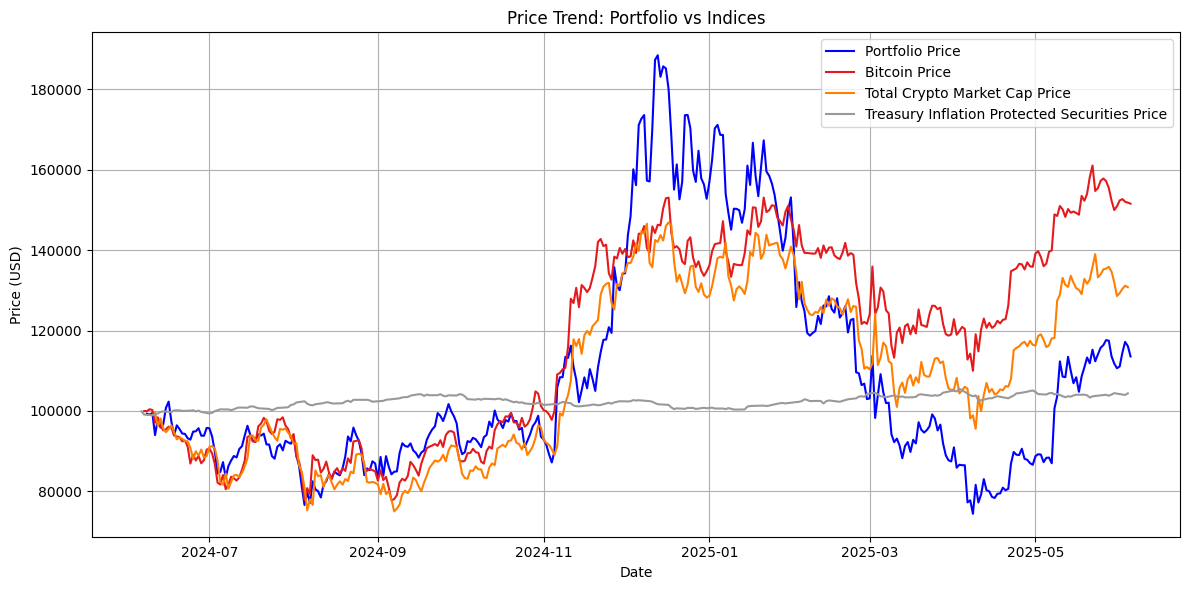

In [334]:
plot_price(portfolio_6_df, index_dict)

### Portfolio Returns Visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


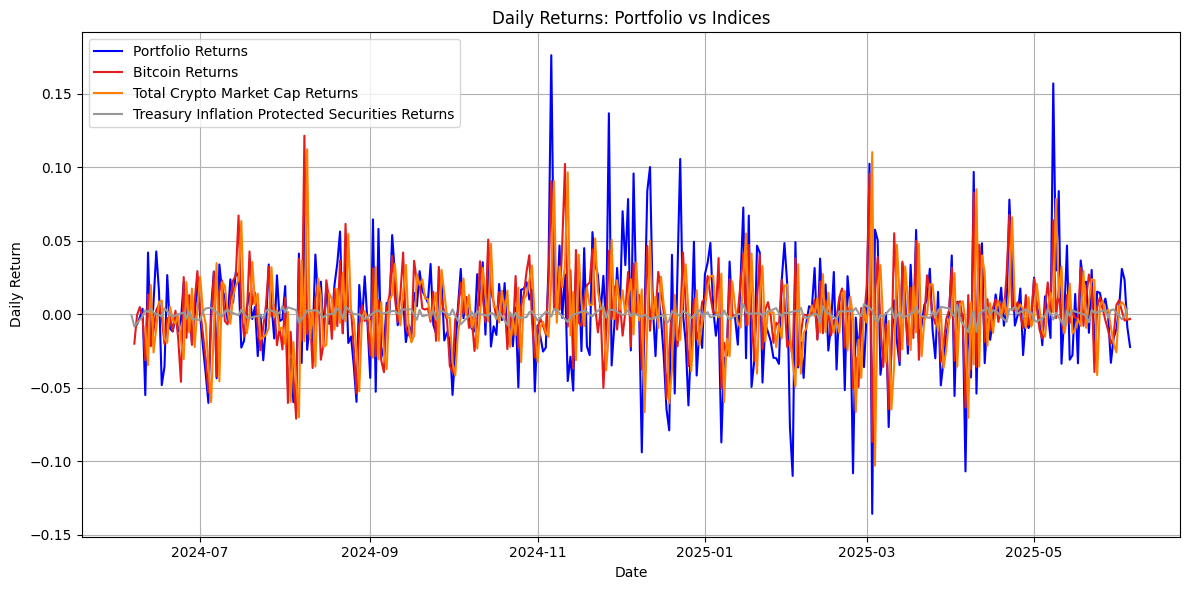

In [335]:
plot_returns(portfolio_6_df, index_dict)

In [336]:
overall_vol_score_6 = calculate_volatility_score(portfolio_6_df, total_data_index)
print(f"Overall Volatility Score: {overall_vol_score_6:.3f}")

Overall Volatility Score: 1.301


### AQM Score:

In [338]:
aqm_6 = calculate_AQM(coin_dict, tip_data)
aqm_df = pd.DataFrame(aqm_6.items(), columns=['Coin', 'AQM'])
aqm_df

Coin       AQM
0   USDC -0.004614
1    BTC -0.290746
2    ETH  0.760443
3    ADA -0.189229
4    SOL  0.096127
5    DOT  0.578391
6   LINK  0.143060
7   AVAX -0.446848
8   DOGE -1.008874
9   SHIB  0.758503
10   UNI  0.361588
11  AAVE  0.462861
12  COMP  1.129555

<h3 style="text-align: center;"><strong>NFT/ Metaverse Portfolio</strong></h3>

- USDC: 10% 
- ETH: 25% 
- SOL: 20% 
- MANA: 15% 
- SAND: 15% 
- ENJ: 15% 

In [339]:
MANA_data = fetch_price('MANA', period='1y')
SAND_data = fetch_price('SAND', period='1y')
ENJ_data = fetch_price('ENJ', period='1y')
coin_dict['MANA'] = MANA_data
coin_dict['SAND'] = SAND_data
coin_dict['ENJ'] = ENJ_data
print(coin_dict.keys())

dict_keys(['USDC', 'BTC', 'ETH', 'ADA', 'SOL', 'DOT', 'LINK', 'AVAX', 'DOGE', 'SHIB', 'UNI', 'AAVE', 'COMP', 'MANA', 'SAND', 'ENJ'])


In [342]:
portfolio_7 = build_portfolio(coin_dict, [0.1, 0, 0.25, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0.15, 0.15, 0.15], investment_amount=100000)

 Portfolio Breakdown:
 - USDC:
    Price: $1.00
    Allocation: $10,000.00
    Total USDC Purchased: 9,999.070254
 - BTC:
    Price: $69,342.59
    Allocation: $0.00
    Total BTC Purchased: 0.000000
 - ETH:
    Price: $3,678.63
    Allocation: $25,000.00
    Total ETH Purchased: 6.796010
 - ADA:
    Price: $0.45
    Allocation: $0.00
    Total ADA Purchased: 0.000000
 - SOL:
    Price: $162.51
    Allocation: $20,000.00
    Total SOL Purchased: 123.071584
 - DOT:
    Price: $6.66
    Allocation: $0.00
    Total DOT Purchased: 0.000000
 - LINK:
    Price: $16.33
    Allocation: $0.00
    Total LINK Purchased: 0.000000
 - AVAX:
    Price: $33.51
    Allocation: $0.00
    Total AVAX Purchased: 0.000000
 - DOGE:
    Price: $0.15
    Allocation: $0.00
    Total DOGE Purchased: 0.000000
 - SHIB:
    Price: $0.00
    Allocation: $0.00
    Total SHIB Purchased: 0.000000
 - UNI:
    Price: $9.82
    Allocation: $0.00
    Total UNI Purchased: 0.000000
 - AAVE:
    Price: $97.45
    Allocation: 

In [343]:
portfolio_7_df = build_portfolio_time_series(coin_dict, portfolio_7)
portfolio_7_df

Close   returns
Date                              
2024-06-08  97002.687255 -0.029973
2024-06-09  98723.979775  0.017745
2024-06-10  97038.248368 -0.017075
2024-06-11  92452.183593 -0.047260
2024-06-12  95186.481307  0.029575
...                  ...       ...
2025-06-01  69857.133954  0.007092
2025-06-02  70819.081201  0.013770
2025-06-03  70438.813908 -0.005370
2025-06-04  69674.302683 -0.010854
2025-06-05  68724.167364 -0.013637

[363 rows x 2 columns]

### Volatility Score

<h4>Against BTC</h4>

In [344]:
MANA_score_btc = calculate_volatility_score(MANA_data, BTC_data)
SAND_score_btc = calculate_volatility_score(SAND_data, BTC_data)
ENJ_score_btc = calculate_volatility_score(ENJ_data, BTC_data)

<h4>Against Total Crypto Market Capitalization</h4>

In [345]:
MANA_score_total = calculate_volatility_score(MANA_data, total_data)
SAND_score_total = calculate_volatility_score(SAND_data, total_data)
ENJ_score_total = calculate_volatility_score(ENJ_data, total_data)

In [346]:
new_rows = [
    {
        'coin': 'MANA',
        'volatility_score_btc': MANA_score_btc,
        'volatility_score_total': MANA_score_total
    },
    {
        'coin': 'SAND',
        'volatility_score_btc': SAND_score_btc,
        'volatility_score_total': SAND_score_total
    },
    {
        'coin': 'ENJ',
        'volatility_score_btc': ENJ_score_btc,
        'volatility_score_total': ENJ_score_total
    }
]
vol_scores = pd.concat([vol_scores, pd.DataFrame(new_rows)], ignore_index=True)
vol_scores

coin  volatility_score_btc  volatility_score_total
0    BTC              1.000000                1.188346
1   USDC              0.000446                0.000530
2    ETH              0.674713                0.801793
3    ADA              2.309213                2.741786
4    SOL              0.897110                1.065161
5    DOT              0.896832                1.065747
6   LINK              1.124675                1.336503
7   AVAX              0.974209                1.157698
8   DOGE              2.787616                3.312652
9   SHIB              0.780437                0.927429
10   UNI              1.255212                1.491626
11  AAVE              3.250028                3.862158
12  COMP              1.220426                1.450289
13  MANA              1.033842                1.228562
14  SAND              1.384623                1.645411
15   ENJ              0.981467                1.166323

### Portfolio Price Visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


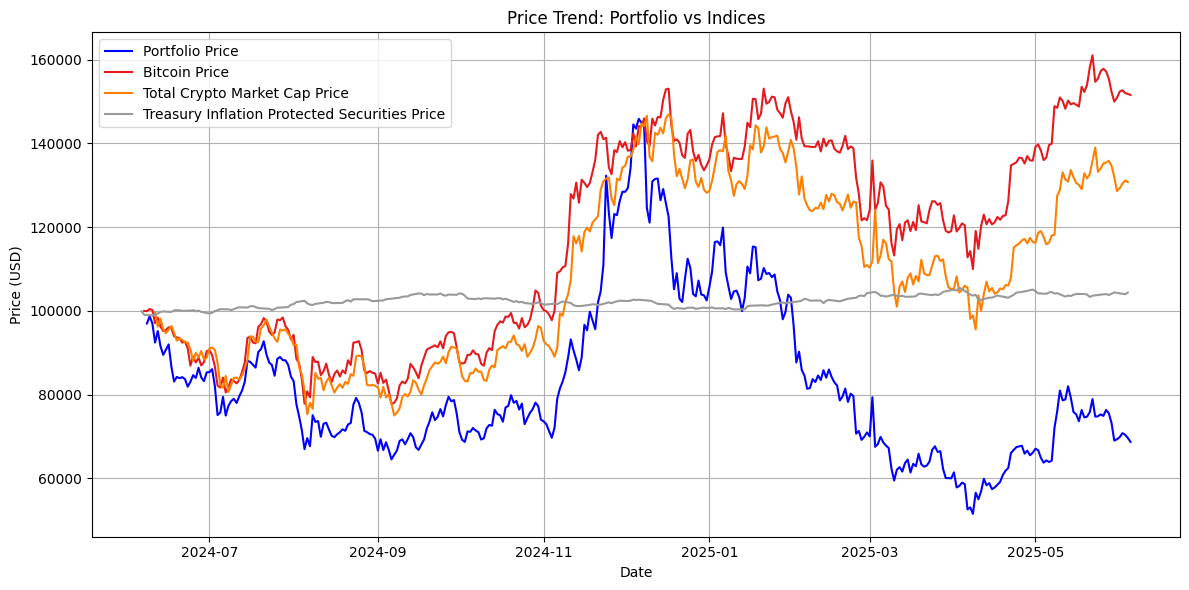

In [347]:
plot_price(portfolio_7_df, index_dict)

### Portfolio Returns Visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


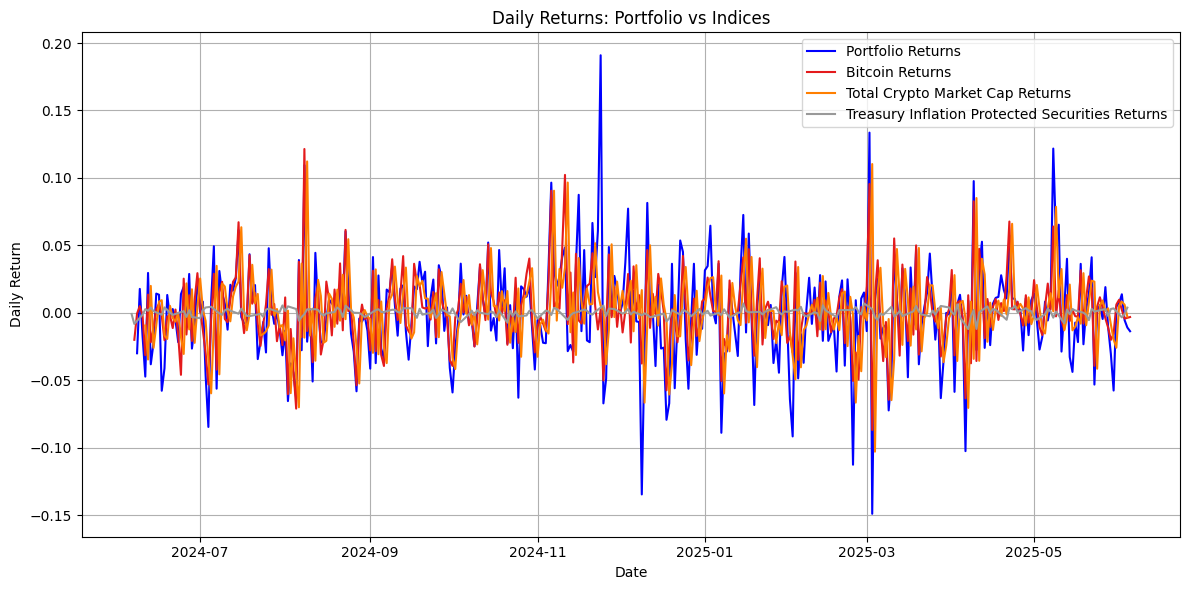

In [348]:
plot_returns(portfolio_7_df, index_dict)

In [364]:
overall_vol_score_7 = calculate_volatility_score(portfolio_7_df, total_data_index)
print(f"Overall Volatility Score: {overall_vol_score_7:.3f}")

Overall Volatility Score: 0.946


### AQM Score:

In [349]:
aqm_7 = calculate_AQM(coin_dict, tip_data)
aqm_df = pd.DataFrame(aqm_7.items(), columns=['Coin', 'AQM'])
aqm_df

Coin       AQM
0   USDC -0.004614
1    BTC -0.290746
2    ETH  0.760443
3    ADA -0.189229
4    SOL  0.096127
5    DOT  0.578391
6   LINK  0.143060
7   AVAX -0.446848
8   DOGE -1.008874
9   SHIB  0.758503
10   UNI  0.361588
11  AAVE  0.462861
12  COMP  1.129555
13  MANA -0.098409
14  SAND  0.495919
15   ENJ  0.522452

<h3 style="text-align: center;"><strong>Tech-Oriented Portfolio</strong></h3>


- USDC: 15% 
- ETH: 25% 
- ADA: 20% 
- DOT: 20% 
- ALGO: 10%
- XTZ: 10% 

In [350]:
ALGO_data = fetch_price('ALGO', period='1y')
XTZ_data = fetch_price('XTZ', period='1y')
coin_dict['ALGO'] = ALGO_data
coin_dict['XTZ'] = XTZ_data
print(coin_dict.keys())

dict_keys(['USDC', 'BTC', 'ETH', 'ADA', 'SOL', 'DOT', 'LINK', 'AVAX', 'DOGE', 'SHIB', 'UNI', 'AAVE', 'COMP', 'MANA', 'SAND', 'ENJ', 'ALGO', 'XTZ'])


### Portfolio Data:

In [353]:
portfolio_8 = build_portfolio(coin_dict, [0.15, 0, 0.25, 0.2, 0, 0.2, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0.1, 0.1], investment_amount=100000)

 Portfolio Breakdown:
 - USDC:
    Price: $1.00
    Allocation: $15,000.00
    Total USDC Purchased: 14,998.605381
 - BTC:
    Price: $69,342.59
    Allocation: $0.00
    Total BTC Purchased: 0.000000
 - ETH:
    Price: $3,678.63
    Allocation: $25,000.00
    Total ETH Purchased: 6.796010
 - ADA:
    Price: $0.45
    Allocation: $20,000.00
    Total ADA Purchased: 44,479.733077
 - SOL:
    Price: $162.51
    Allocation: $0.00
    Total SOL Purchased: 0.000000
 - DOT:
    Price: $6.66
    Allocation: $20,000.00
    Total DOT Purchased: 3,004.010285
 - LINK:
    Price: $16.33
    Allocation: $0.00
    Total LINK Purchased: 0.000000
 - AVAX:
    Price: $33.51
    Allocation: $0.00
    Total AVAX Purchased: 0.000000
 - DOGE:
    Price: $0.15
    Allocation: $0.00
    Total DOGE Purchased: 0.000000
 - SHIB:
    Price: $0.00
    Allocation: $0.00
    Total SHIB Purchased: 0.000000
 - UNI:
    Price: $9.82
    Allocation: $0.00
    Total UNI Purchased: 0.000000
 - AAVE:
    Price: $97.45
   

In [354]:
portfolio_8_df = build_portfolio_time_series(coin_dict, portfolio_8)
portfolio_8_df

Close   returns
Date                              
2024-06-08  97632.601171 -0.023674
2024-06-09  99016.614086  0.014176
2024-06-10  98263.878380 -0.007602
2024-06-11  95139.288869 -0.031798
2024-06-12  98103.616827  0.031158
...                  ...       ...
2025-06-01  92620.961689  0.000396
2025-06-02  93876.176100  0.013552
2025-06-03  93510.861025 -0.003891
2025-06-04  91963.766344 -0.016545
2025-06-05  91112.314766 -0.009259

[363 rows x 2 columns]

### Volatility Score:

<h4>Against BTC</h4>

In [357]:
ALGO_score_btc = calculate_volatility_score(ALGO_data, BTC_data)
XTZ_score_btc = calculate_volatility_score(XTZ_data, BTC_data)

<h4>Against Total Crypto Market Capitalization</h4>

In [355]:
ALGO_score_total = calculate_volatility_score(ALGO_data, total_data)
XTZ_score_total = calculate_volatility_score(XTZ_data, total_data)

In [360]:
new_rows = [
    {
        'coin': 'ALGO',
        'volatility_score_btc': ALGO_score_btc,
        'volatility_score_total': ALGO_score_total
    },
    {
        'coin': 'XTZ',
        'volatility_score_btc': XTZ_score_btc,
        'volatility_score_total': XTZ_score_total
    }
]
vol_scores = pd.concat([vol_scores, pd.DataFrame(new_rows)], ignore_index=True)
vol_scores

coin  volatility_score_btc  volatility_score_total
0    BTC              1.000000                1.188346
1   USDC              0.000446                0.000530
2    ETH              0.674713                0.801793
3    ADA              2.309213                2.741786
4    SOL              0.897110                1.065161
5    DOT              0.896832                1.065747
6   LINK              1.124675                1.336503
7   AVAX              0.974209                1.157698
8   DOGE              2.787616                3.312652
9   SHIB              0.780437                0.927429
10   UNI              1.255212                1.491626
11  AAVE              3.250028                3.862158
12  COMP              1.220426                1.450289
13  MANA              1.033842                1.228562
14  SAND              1.384623                1.645411
15   ENJ              0.981467                1.166323
16  ALGO              2.370494                2.816968
17   XTZ              1.333901                1.585136

### Portfolio Price Visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


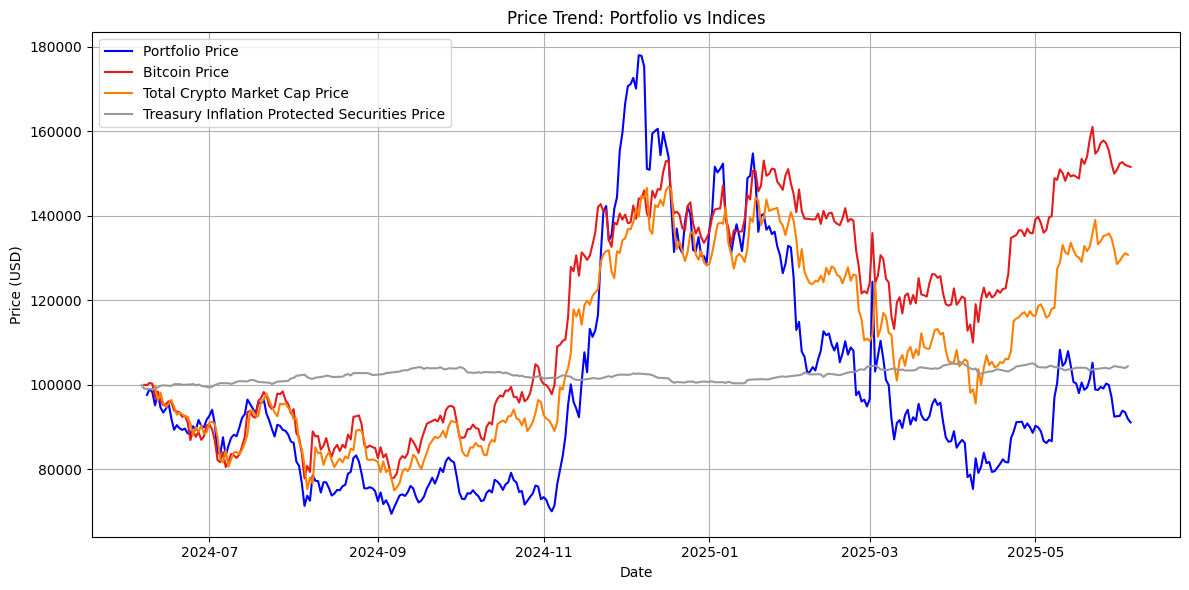

In [361]:
plot_price(portfolio_8_df, index_dict)

### Portfolio Return Visualization

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


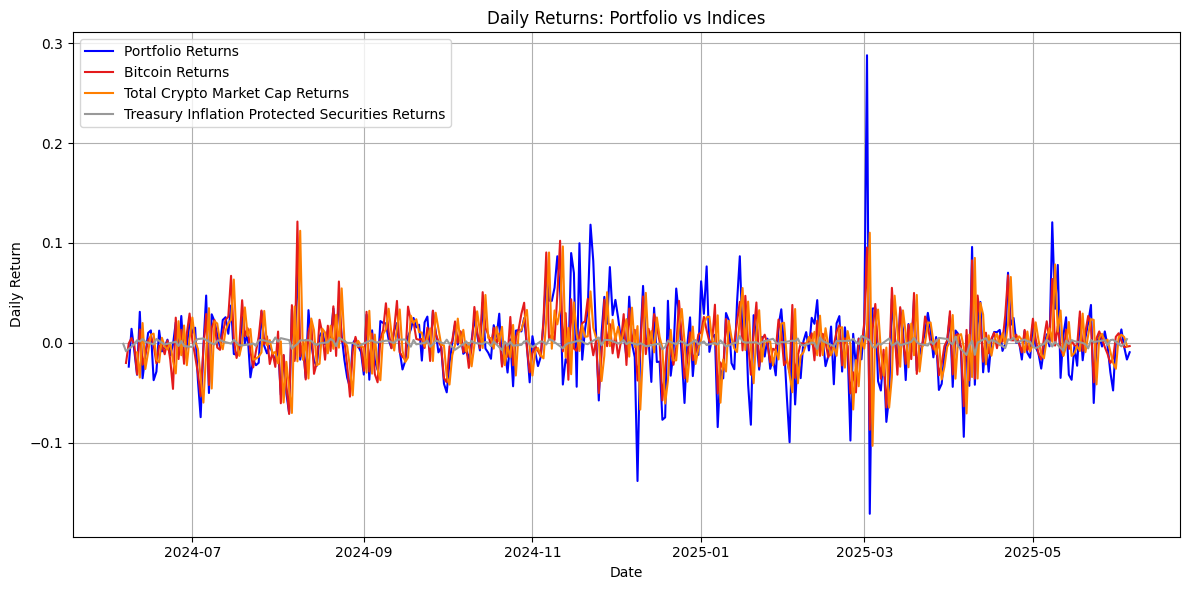

In [362]:
plot_returns(portfolio_8_df, index_dict)

In [363]:
overall_vol_score_8 = calculate_volatility_score(portfolio_8_df, total_data_index)
print(f"Overall Volatility Score: {overall_vol_score_8:.3f}")

Overall Volatility Score: 1.252


### AQM Score:

In [365]:
aqm_8 = calculate_AQM(coin_dict, tip_data)
aqm_df = pd.DataFrame(aqm_8.items(), columns=['Coin', 'AQM'])
aqm_df

Coin       AQM
0   USDC -0.004614
1    BTC -0.290746
2    ETH  0.760443
3    ADA -0.189229
4    SOL  0.096127
5    DOT  0.578391
6   LINK  0.143060
7   AVAX -0.446848
8   DOGE -1.008874
9   SHIB  0.758503
10   UNI  0.361588
11  AAVE  0.462861
12  COMP  1.129555
13  MANA -0.098409
14  SAND  0.495919
15   ENJ  0.522452
16  ALGO  1.157324
17   XTZ  0.987606

<h3 style="text-align: center;"><strong>Ultra-Diversified Portfolio</strong></h3>

- USDC: 10% 
- BTC: 10% 
- ETH: 10% 
- BNB: 10% 
- XRP: 10% 
- DOT: 10%
- ADA: 10% 
- SOL: 10% 
- DOGE: 10% 
- SHIB: 10% 

In [366]:
BNB_data = fetch_price('BNB', period='1y')
XRP_data = fetch_price('XRP', period='1y')
coin_dict['BNB'] = BNB_data
coin_dict['XRP'] = XRP_data
print(coin_dict.keys())

dict_keys(['USDC', 'BTC', 'ETH', 'ADA', 'SOL', 'DOT', 'LINK', 'AVAX', 'DOGE', 'SHIB', 'UNI', 'AAVE', 'COMP', 'MANA', 'SAND', 'ENJ', 'ALGO', 'XTZ', 'BNB', 'XRP'])


### Portfolio Data:

In [370]:
portfolio_9 = build_portfolio(coin_dict, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0, 0, 0.1, 0.1, 0, 0, 0, 0, 0, 0,
                                          0, 0, 0.1, 0.1], investment_amount=100000)

 Portfolio Breakdown:
 - USDC:
    Price: $1.00
    Allocation: $10,000.00
    Total USDC Purchased: 9,999.070254
 - BTC:
    Price: $69,342.59
    Allocation: $10,000.00
    Total BTC Purchased: 0.144212
 - ETH:
    Price: $3,678.63
    Allocation: $10,000.00
    Total ETH Purchased: 2.718404
 - ADA:
    Price: $0.45
    Allocation: $10,000.00
    Total ADA Purchased: 22,239.866539
 - SOL:
    Price: $162.51
    Allocation: $10,000.00
    Total SOL Purchased: 61.535792
 - DOT:
    Price: $6.66
    Allocation: $10,000.00
    Total DOT Purchased: 1,502.005143
 - LINK:
    Price: $16.33
    Allocation: $0.00
    Total LINK Purchased: 0.000000
 - AVAX:
    Price: $33.51
    Allocation: $0.00
    Total AVAX Purchased: 0.000000
 - DOGE:
    Price: $0.15
    Allocation: $10,000.00
    Total DOGE Purchased: 67,429.518331
 - SHIB:
    Price: $0.00
    Allocation: $10,000.00
    Total SHIB Purchased: 416,666,651.928811
 - UNI:
    Price: $9.82
    Allocation: $0.00
    Total UNI Purchased: 0.00

In [371]:
portfolio_9_df = build_portfolio_time_series(coin_dict, portfolio_9)
portfolio_9_df

Close   returns
Date                               
2024-06-08   98331.173504 -0.016688
2024-06-09   99090.655513  0.007724
2024-06-10   97773.808852 -0.013289
2024-06-11   94303.606682 -0.035492
2024-06-12   96865.129202  0.027163
...                   ...       ...
2025-06-01  134996.252197  0.002783
2025-06-02  135974.138288  0.007244
2025-06-03  136409.301266  0.003200
2025-06-04  134433.005517 -0.014488
2025-06-05  132224.708419 -0.016427

[363 rows x 2 columns]

### Volatility Score:

<h4>Against BTC</h4>

In [372]:
BNB_score_btc = calculate_volatility_score(BNB_data, BTC_data)
XRP_score_btc = calculate_volatility_score(XRP_data, BTC_data)

<h4>Against Total Crypto Market Capitalization</h4>

In [373]:
BNB_score_total = calculate_volatility_score(BNB_data, total_data)
XRP_score_total = calculate_volatility_score(XRP_data, total_data)

In [374]:
new_rows = [
    {
        'coin': 'BNB',
        'volatility_score_btc': BNB_score_btc,
        'volatility_score_total': BNB_score_total
    },
    {
        'coin': 'XRP',
        'volatility_score_btc': XRP_score_btc,
        'volatility_score_total': XRP_score_total
    }
]
vol_scores = pd.concat([vol_scores, pd.DataFrame(new_rows)], ignore_index=True)
vol_scores

coin  volatility_score_btc  volatility_score_total
0    BTC              1.000000                1.188346
1   USDC              0.000446                0.000530
2    ETH              0.674713                0.801793
3    ADA              2.309213                2.741786
4    SOL              0.897110                1.065161
5    DOT              0.896832                1.065747
6   LINK              1.124675                1.336503
7   AVAX              0.974209                1.157698
8   DOGE              2.787616                3.312652
9   SHIB              0.780437                0.927429
10   UNI              1.255212                1.491626
11  AAVE              3.250028                3.862158
12  COMP              1.220426                1.450289
13  MANA              1.033842                1.228562
14  SAND              1.384623                1.645411
15   ENJ              0.981467                1.166323
16  ALGO              2.370494                2.816968
17   XTZ              1.333901                1.585136
18   BNB              0.346784                0.412100
19   XRP              7.585501                9.014201

### Portfolio Price Visualization

In [377]:
# I was wondering why XRP's volatility score for both btc and total are so high
xrp_copy = XRP_data.copy()
xrp_start_price = 100_000 / xrp_copy['Close'].iloc[0]  # to reflect $100k worth of XRP at last year perfectly
xrp_copy['Close'] = xrp_copy['Close'] * xrp_start_price
xrp_copy

Close   returns
Date                               
2024-06-07  100000.000000 -0.043382
2024-06-08   98836.358845 -0.011636
2024-06-09   99926.245446  0.011027
2024-06-10   99534.422883 -0.003921
2024-06-11   96265.969626 -0.032837
...                   ...       ...
2025-06-01  436753.110453  0.001896
2025-06-02  440475.147051  0.008522
2025-06-03  450313.579302  0.022336
2025-06-04  441388.059754 -0.019821
2025-06-05  433803.358341 -0.017184

[364 rows x 2 columns]

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


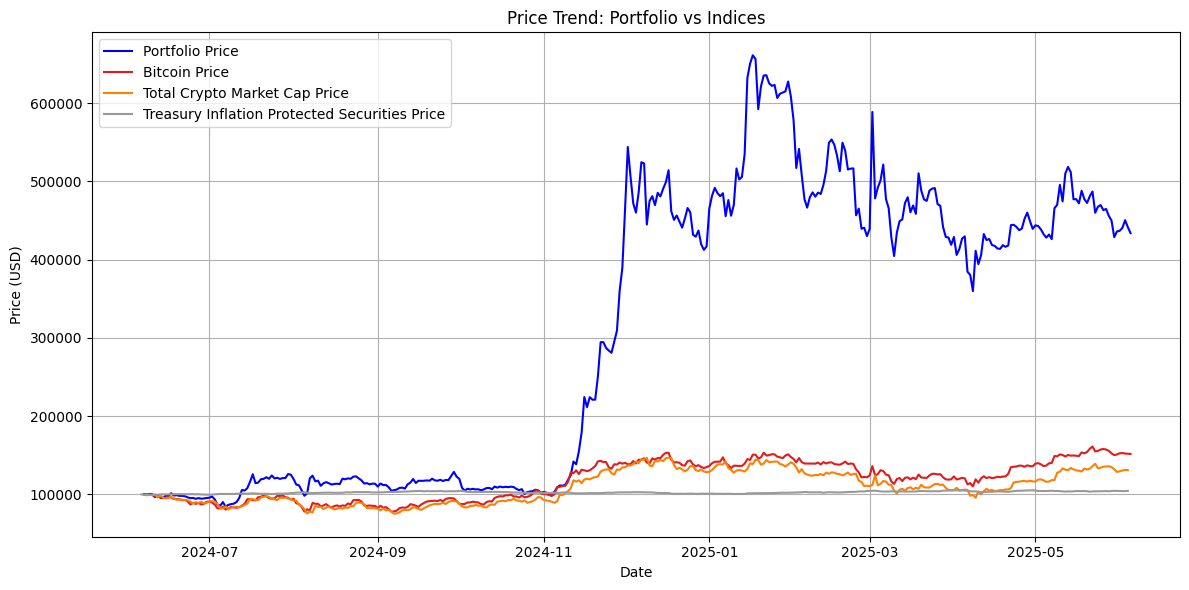

In [378]:
plot_price(xrp_copy, index_dict)

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


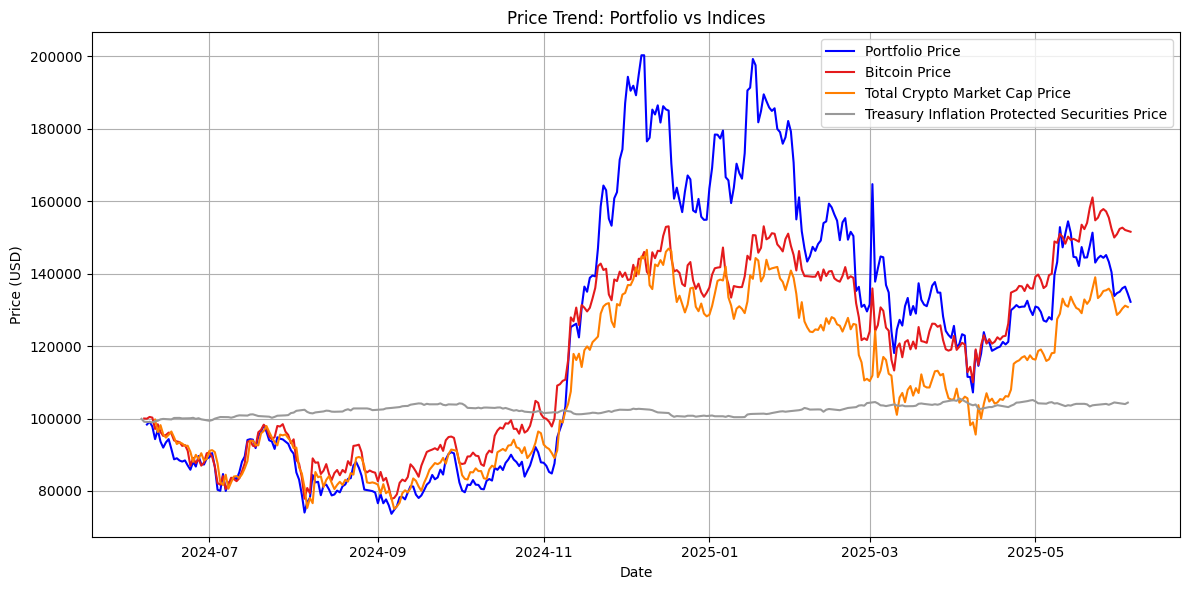

In [379]:
plot_price(portfolio_9_df, index_dict)

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


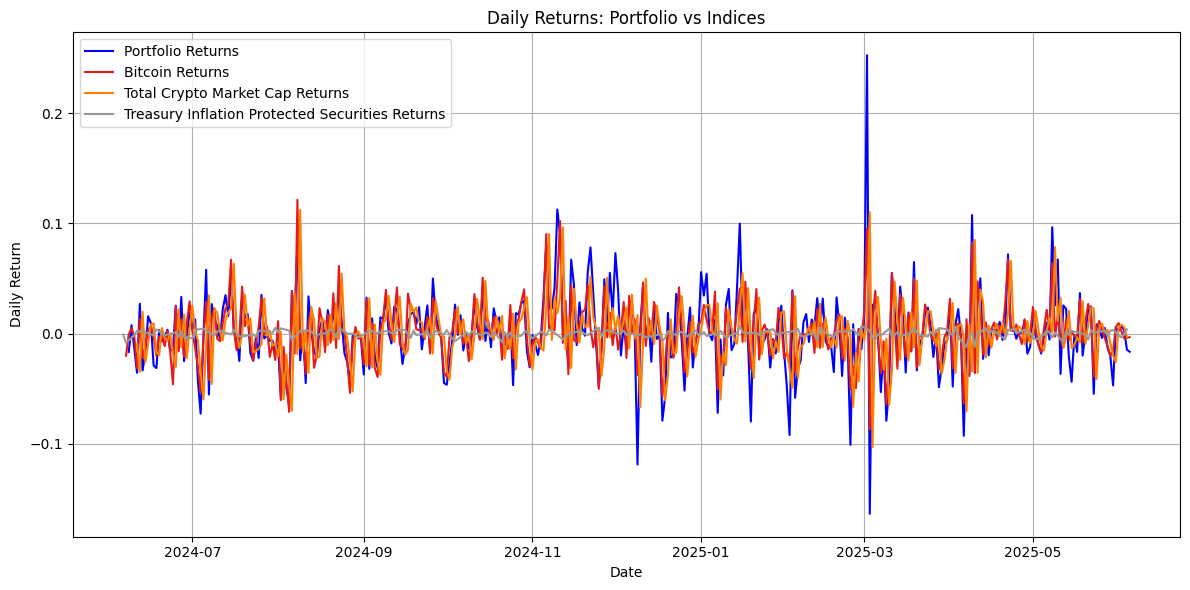

In [380]:
plot_returns(portfolio_9_df, index_dict)

### AQM Score:

In [381]:
aqm_9 = calculate_AQM(coin_dict, tip_data)
aqm_df = pd.DataFrame(aqm_9.items(), columns=['Coin', 'AQM'])
aqm_df

Coin       AQM
0   USDC -0.004614
1    BTC -0.290746
2    ETH  0.760443
3    ADA -0.189229
4    SOL  0.096127
5    DOT  0.578391
6   LINK  0.143060
7   AVAX -0.446848
8   DOGE -1.008874
9   SHIB  0.758503
10   UNI  0.361588
11  AAVE  0.462861
12  COMP  1.129555
13  MANA -0.098409
14  SAND  0.495919
15   ENJ  0.522452
16  ALGO  1.157324
17   XTZ  0.987606
18   BNB -0.882607
19   XRP -0.014180

<h3 style="text-align: center;"><strong>Aggresive Small-Cap Portfolio</strong></h3>

This portfolio was not successfully simulated, MATIC and FTM's ticker were changed. MATIC-USD was changed to POL-USD and FTM-USD was changed to S32684-USD
<strong>(These reasons have to be verified)</strong>

Because of that, I changed MATIC to ARB and FTM to NEAR, very similar coins in terms of sector and market cap

- USDC: 5% 
- BTC: 15% 
- ETH: 10% 
- ARB: 20% 
- ATOM: 20% 
- NEAR: 15% 
- HBAR: 15% 

In [431]:
matic_data = coin_dict.pop('MATIC', None)

In [432]:
ARB_data = fetch_price('ARB', period='1y')
NEAR_data = fetch_price('NEAR', period='1y')
ATOM_data = fetch_price('ATOM', period='1y')
HBAR_data = fetch_price('HBAR', period='1y')
coin_dict['ATOM'] = ATOM_data
coin_dict['ARB'] = ARB_data
coin_dict['NEAR'] = NEAR_data
coin_dict['HBAR'] = HBAR_data
print(coin_dict.keys())

dict_keys(['USDC', 'BTC', 'ETH', 'ADA', 'SOL', 'DOT', 'LINK', 'AVAX', 'DOGE', 'SHIB', 'UNI', 'AAVE', 'COMP', 'MANA', 'SAND', 'ENJ', 'ALGO', 'XTZ', 'BNB', 'XRP', 'ATOM', 'HBAR', 'ARB', 'NEAR'])


### Portfolio Data:

In [433]:
portfolio_10 = build_portfolio(coin_dict, [
    0.05,
    0.15,
    0.10,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.20,
    0.15,
    0.20,
    0.15
], investment_amount=100000)

 Portfolio Breakdown:
 - USDC:
    Price: $1.00
    Allocation: $5,000.00
    Total USDC Purchased: 4,999.535127
 - BTC:
    Price: $69,342.59
    Allocation: $15,000.00
    Total BTC Purchased: 0.216317
 - ETH:
    Price: $3,678.63
    Allocation: $10,000.00
    Total ETH Purchased: 2.718404
 - ADA:
    Price: $0.45
    Allocation: $0.00
    Total ADA Purchased: 0.000000
 - SOL:
    Price: $162.51
    Allocation: $0.00
    Total SOL Purchased: 0.000000
 - DOT:
    Price: $6.66
    Allocation: $0.00
    Total DOT Purchased: 0.000000
 - LINK:
    Price: $16.33
    Allocation: $0.00
    Total LINK Purchased: 0.000000
 - AVAX:
    Price: $33.51
    Allocation: $0.00
    Total AVAX Purchased: 0.000000
 - DOGE:
    Price: $0.15
    Allocation: $0.00
    Total DOGE Purchased: 0.000000
 - SHIB:
    Price: $0.00
    Allocation: $0.00
    Total SHIB Purchased: 0.000000
 - UNI:
    Price: $9.82
    Allocation: $0.00
    Total UNI Purchased: 0.000000
 - AAVE:
    Price: $97.45
    Allocation: $0.

In [434]:
portfolio_10_df = build_portfolio_time_series(coin_dict, portfolio_10)
portfolio_10_df

Close   returns
Date                              
2024-06-08  97886.898381 -0.021131
2024-06-09  98651.158323  0.007808
2024-06-10  97593.277626 -0.010723
2024-06-11  94232.668551 -0.034435
2024-06-12  96914.495495  0.028460
...                  ...       ...
2025-06-01  93029.504816  0.005819
2025-06-02  94083.199709  0.011326
2025-06-03  93880.772299 -0.002152
2025-06-04  92532.761815 -0.014359
2025-06-05  91665.977654 -0.009367

[363 rows x 2 columns]

### Volatility Score

<h4>Against BTC</h4>

In [436]:
ARB_score_btc = calculate_volatility_score(ARB_data, BTC_data)
ATOM_score_btc = calculate_volatility_score(ATOM_data, BTC_data)
NEAR_score_btc = calculate_volatility_score(NEAR_data, BTC_data)
HBAR_score_btc = calculate_volatility_score(HBAR_data, BTC_data)

<h4>Against Total Crypto Market Capitalization</h4>

In [437]:
ARB_score_total = calculate_volatility_score(ARB_data, total_data)
ATOM_score_total = calculate_volatility_score(ATOM_data, total_data)
NEAR_score_total = calculate_volatility_score(NEAR_data, total_data)
HBAR_score_total = calculate_volatility_score(HBAR_data, total_data)

In [438]:
new_rows = [
    {
        'coin': 'ARB',
        'volatility_score_btc': ARB_score_btc,
        'volatility_score_total': ARB_score_total
    },
    {
        'coin': 'ATOM',
        'volatility_score_btc': ATOM_score_btc,
        'volatility_score_total': ATOM_score_total
    },
    {
        'coin': 'NEAR',
        'volatility_score_btc': NEAR_score_btc,
        'volatility_score_total': NEAR_score_total
    },
    {
        'coin': 'HBAR',
        'volatility_score_btc': HBAR_score_btc,
        'volatility_score_total': HBAR_score_total
    }
]
vol_scores = pd.concat([vol_scores, pd.DataFrame(new_rows)], ignore_index=True)
vol_scores

coin  volatility_score_btc  volatility_score_total
0    BTC              1.000000                1.188346
1   USDC              0.000446                0.000530
2    ETH              0.674713                0.801793
3    ADA              2.309213                2.741786
4    SOL              0.897110                1.065161
5    DOT              0.896832                1.065747
6   LINK              1.124675                1.336503
7   AVAX              0.974209                1.157698
8   DOGE              2.787616                3.312652
9   SHIB              0.780437                0.927429
10   UNI              1.255212                1.491626
11  AAVE              3.250028                3.862158
12  COMP              1.220426                1.450289
13  MANA              1.033842                1.228562
14  SAND              1.384623                1.645411
15   ENJ              0.981467                1.166323
16  ALGO              2.370494                2.816968
17   XTZ              1.333901                1.585136
18   BNB              0.346784                0.412100
19   XRP              7.585501                9.014201
20   ARB              0.860496                1.022568
21  ATOM              0.694650                0.825485
22  NEAR              0.812517                0.965551
23  HBAR              4.026957                4.785419

### Portfolio Price Visualization

HBAR also has a very big volatility score:

In [440]:
HBAR_copy = HBAR_data.copy()
HBAR_start_price = 100_000 / HBAR_copy['Close'].iloc[0]  # to reflect $100k worth of HBAR at last year perfectly
HBAR_copy['Close'] = HBAR_copy['Close'] * HBAR_start_price
HBAR_copy

Close   returns
Date                               
2024-06-07  100000.000000 -0.073056
2024-06-08   96091.779879 -0.039082
2024-06-09   97271.475611  0.012277
2024-06-10   94794.001239 -0.025470
2024-06-11   92924.995835 -0.019716
...                   ...       ...
2025-06-01  179374.936496  0.006452
2025-06-02  182399.187281  0.016860
2025-06-03  182823.616835  0.002327
2025-06-04  177867.606067 -0.027108
2025-06-05  175649.004241 -0.012473

[364 rows x 2 columns]

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


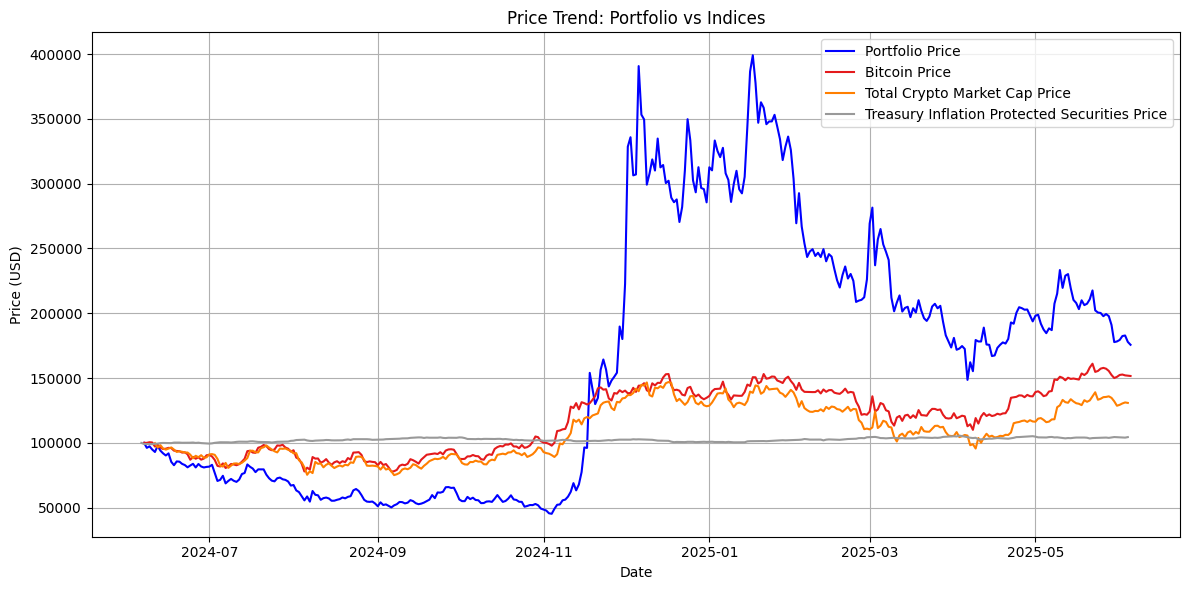

In [441]:
plot_price(HBAR_copy, index_dict)

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


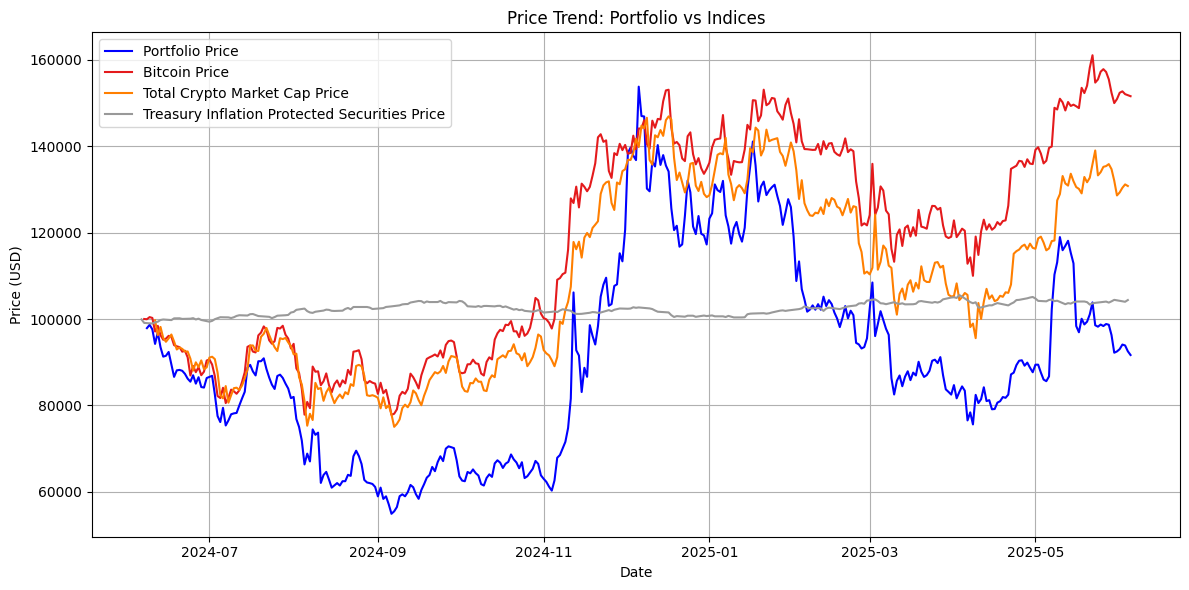

In [442]:
plot_price(portfolio_10_df, index_dict)

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


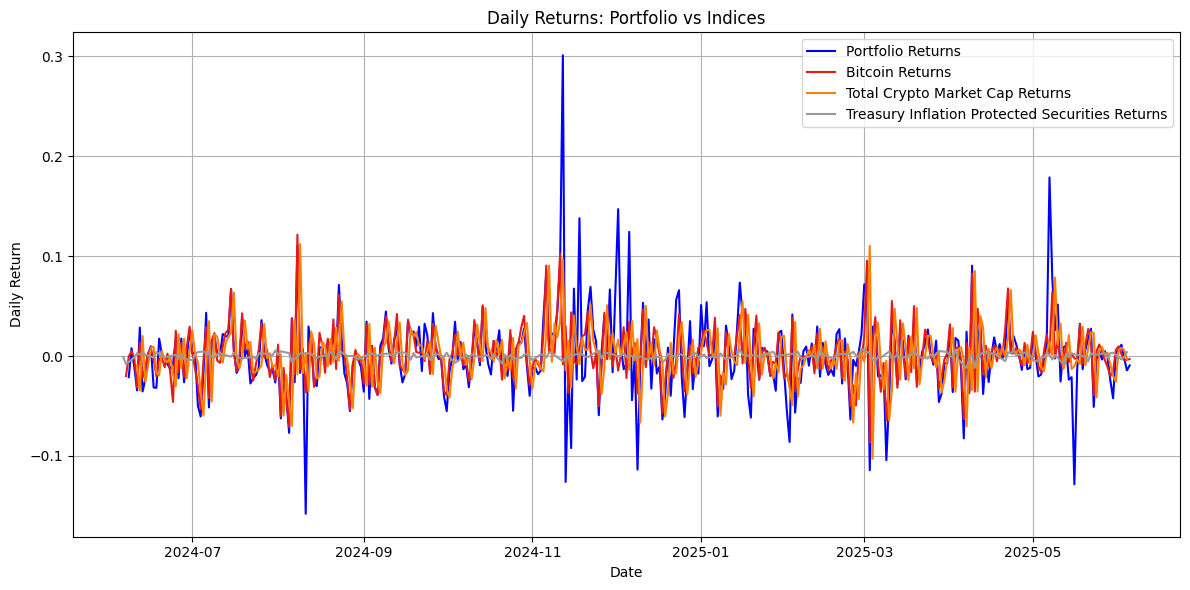

In [443]:
plot_returns(portfolio_10_df, index_dict)

<h3>AQM Score</h3>

In [444]:
aqm_10 = calculate_AQM(coin_dict, tip_data)
aqm_df = pd.DataFrame(aqm_10.items(), columns=['Coin', 'AQM'])
aqm_df

Coin       AQM
0   USDC -0.004614
1    BTC -0.290746
2    ETH  0.760443
3    ADA -0.189229
4    SOL  0.096127
5    DOT  0.578391
6   LINK  0.143060
7   AVAX -0.446848
8   DOGE -1.008874
9   SHIB  0.758503
10   UNI  0.361588
11  AAVE  0.462861
12  COMP  1.129555
13  MANA -0.098409
14  SAND  0.495919
15   ENJ  0.522452
16  ALGO  1.157324
17   XTZ  0.987606
18   BNB -0.882607
19   XRP -0.014180
20  ATOM  0.348182
21  HBAR -0.270757
22   ARB -4.488600
23  NEAR -0.037426

ARB has an abnormaly high AQM

/var/folders/5r/1lsvb2gx50n91j4gfq7gvff80000gn/T/ipykernel_1020/4180322575.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(index_dict))


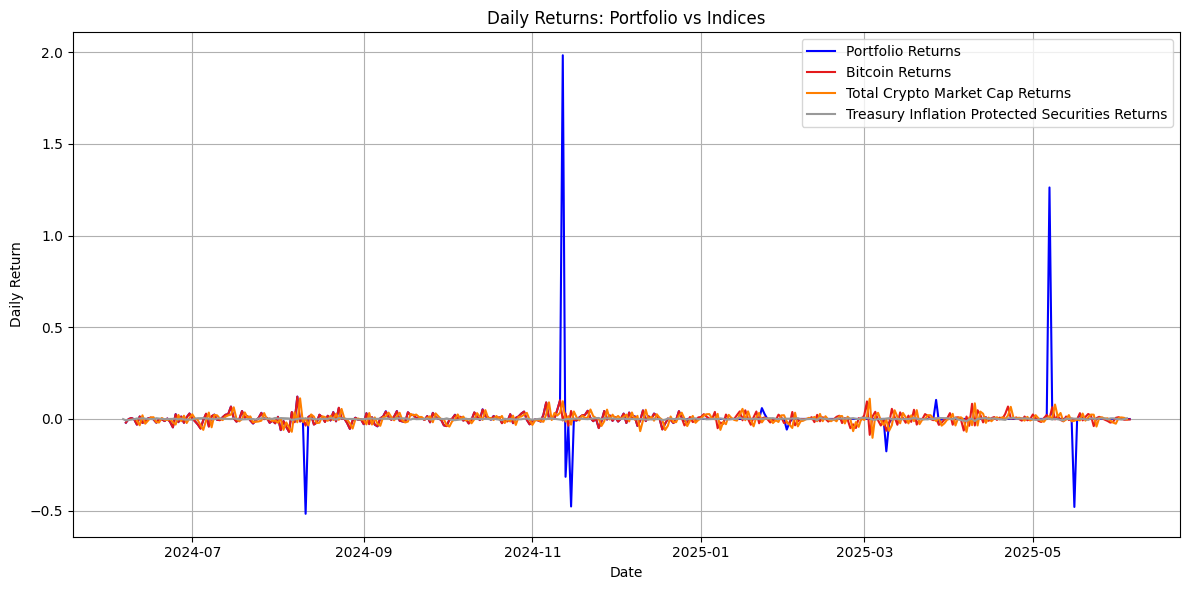

In [446]:
plot_returns(ARB_data, index_dict)

<h2>Summary and Conclusions</h2>